# Generate Figures for IJCAI submission 

**Paper:** *Solving the Identifying Code Set Problem with Independent Support*

**By:** Anna L.D. Latour, Arunabha Sen, Kuldeep S. Meel
    
**Presented at:** IJCAI 2023, paper #4051

**Contact:** latour@nus.edu.sg


Copyright (C) 2022 Anna L.D. Latour

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in
all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
THE SOFTWARE.


### Research questions

We generate the figures for four main research questions:

**Q1**: How many instances are solved by `gismo` and `PBPBS`?

**Q2**: How do the solving times of `gismo` and `PBPBS` scale with $k$ and $|V|$?

**Q3**: How does the model size of the CNF encoding scale with $k$ and $|V|$?

**Q4**: How do the solution qualities of `gismo` and `PBPBS` compare?


### Prerequisites

Make sure that the following environment variables are defined:

- `LOCAL_PROJECT_DIR`: the directory with all the project code.
- `DATA_DIR`: the directory to store all the raw output files from the experiments, as well as the json files obtained after parsing.

Also, the following scripts need to be run in order to generate json files with experimental data, obtained from parsing the raw output files from the experiments:

```bash
user@machine:~$ cd $LOCAL_PROJECT_DIR/scripts/data-analysis
user@machine data-analysis$ python parse_files.py --expid IC22 --exptype encoding --enctype gis
user@machine data-analysis$ python parse_files.py --expid IC23 --exptype gis
user@machine data-analysis$ python parse_files.py --expid IC24 --exptype encoding --enctype ilp
user@machine data-analysis$ python parse_files.py --expid IC25 --exptype ilp
user@machine data-analysis$ python collect_network_stats.py
```

In [2]:
# Generally useful packages:
import gzip
import json
import os
import re
import sys

# Packages for manipulating data:
import copy
import numpy as np
import pandas as pd
from math import ceil, floor, log, sqrt
from scipy.optimize import least_squares
from statistics import median, mean

# Packages for making figures (that look good):
import matplotlib
matplotlib.use("TkAgg")
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.legend import Legend
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tolatex

%matplotlib inline

# Helper script for processing json files with results:
LOCAL_PROJECT_DIR = os.getenv('PROJECT_DIR')
sys.path.insert(1, f'{LOCAL_PROJECT_DIR}/scripts/data-analysis')
from data_aggregator import DataAggregator

In [3]:
# Define helpful directories:
DATA_DIR = os.getenv('DATA_DIR')
JSON_DIR = f'{DATA_DIR}/exp-data'
NETWORK_DIR = f'{DATA_DIR}/instances/networks'
STATS_DIR = f'{DATA_DIR}/exp-data/network-stats'

In [4]:
save_png = False

## Setup

### Define the scope

We will generate figures and tables for both the GIS and the ILP pipeline.

**IC22**: Encoding the graphs into CNF/GIS.

**IC23**: Solving the GIS instances with gismo.

**IC24**: Encoding the graphs into ILP.

**IC25**: MIP-solving the ILPs with CPLEX.

In [5]:
# Experiment IDs
gis_enc_expid = 'IC22'
ilp_enc_expid = 'IC24'
gis_sol_expid = 'IC23'
ilp_sol_expid = 'IC25'

# Subdirectories in which the networks are stored
networktypes = [
    'kaustav', 'geometric',
    'infrastructure', 'power', 'road', 'webgraph',
    'collaboration', 'social'
]

# Values for maximum identifiable set size
k_values = ['1', '2', '3', '4', '6', '8', '10', '12', '16']

# ILP encoding configurations
ilp_configs = [
    'config0',   # No optimisations
    'config1'    # Remove supersets
]
gis_configs = ['config-0']   # No choice in configuration, because we didn't implement any

# JSON fields for the encoding step
enc_fields = {
    'output_header': ['benchmark', 'network_type', 'encoding', 'configuration'],
    'encoding_details': ['k'],
    'network_data': ['n_nodes', 'n_edges'],
    'cnf_data': ['n_vars', 'n_clauses', 'n_groups', 'n_Avars'],
    'timeout_info': ['utime', 'max_res_set_size', 'exit_status'],
    'ilp_data': ['n_vars', 'n_csts'],
  }

# JSON fields for the solving step
solve_fields = {
    'output_header': [
        'benchmark', 'network_type',
        'timeout', 'memory_limit'
    ],
    'timeout_info': [
        'utime', 'stime', 'wtime',
        'max_res_set_size',
        'exit_status', 'signal'
    ],
    'cplex_info': [
        'solution_time',
        'deterministic_time',
        'memout',
        'all_rows_eliminated_during_preprocessing',
        'n_rows', 'n_non_zeros', 'n_binaries'
    ],
    'solution_info': [
        'optimised_value',
        'k'
    ]
}

# Make JSON fields encoding-specific

ilp_enc_fields = copy.deepcopy(enc_fields)
ilp_enc_fields['output_header'].append('ilp_configuration')
ilp_enc_fields['encoding_details'].extend(['encoding_t/o', 'building_successful', 'encoding_successful'])

gis_enc_fields = copy.deepcopy(enc_fields)
gis_enc_fields['cnf_data'] = ['n_vars', 'n_clauses', 'n_groups', 'n_Avars']

ilp_sol_fields = copy.deepcopy(solve_fields)
ilp_enc_fields['ilp_data'] = ['n_vars', 'n_csts']
ilp_sol_fields['output_header'].append('ilp_configuration')

gis_sol_fields = copy.deepcopy(solve_fields)
gis_sol_fields['cnf_data'] = ['n_vars', 'n_clauses', 'n_groups', 'n_Avars']
gis_sol_fields['arjun_info'] = ['arjun_time']


### Define experimental parameters


In [6]:
enc_timeout = 3600
sol_timeout = 7200

tot_timeout = 3600     # We use this to evaluate the entire pipeline

enc_memout = 4000000   # 4 GB
sol_memout = 4000000   # 4 GB

penalty_factor = 2

### Specify the relevant networks

In [7]:
# The file with relevant networks contains the networks that we consider for the
# experiments. They are selected as real-world networks of varying sizes that
# do not contain any errors in their encoding.

relevant_networks = []
relevant_network_file = f'{LOCAL_PROJECT_DIR}/scripts/data-analysis/relevant_networks.txt'
with open(relevant_network_file, 'r') as infile:
    relevant_networks = [line.replace('.gz\n', '') for line in infile.readlines()]
print("Number of relevant networks:", len(relevant_networks))

relevant_networks_social = []
relevant_networks_social_file = f'{LOCAL_PROJECT_DIR}/scripts/data-analysis/relevant_networks_social.txt'
with open(relevant_networks_social_file, 'r') as infile:
    relevant_networks_social = [line.replace('.gz\n', '') for line in infile.readlines()]
print("Number of relevant social networks:", len(relevant_networks_social))

relevant_networks_grid = []
relevant_networks_grid_file = f'{LOCAL_PROJECT_DIR}/scripts/data-analysis/relevant_networks_grids.txt'
with open(relevant_networks_grid_file, 'r') as infile:
    relevant_networks_grid = [line.replace('.gz\n', '') for line in infile.readlines()]
print("Number of relevant grid networks:", len(relevant_networks_grid))

Number of relevant networks: 50
Number of relevant social networks: 32
Number of relevant grid networks: 18


## Get the data

### Load the data

We first identify and load all the relevant datasets. Here is a description of the experiment IDs:

In [8]:
ilp_enc_data = DataAggregator(
    ilp_enc_expid, 
    'encoding', 
    JSON_DIR,
    encodings=['ilp'],
    k_values=k_values,
    network_types=networktypes,
    configs=ilp_configs,
    relevant_fields=ilp_enc_fields
).get_data()

gis_enc_data = DataAggregator(
    gis_enc_expid, 
    'encoding', 
    JSON_DIR,
    encodings=['gis'],
    k_values=k_values,
    network_types=networktypes,
    configs=gis_configs,
    relevant_fields=gis_enc_fields
).get_data()

ilp_sol_data = DataAggregator(
    ilp_sol_expid, 
    'ilp', 
    JSON_DIR,
    encodings=['ilp'],
    k_values=k_values,
    network_types=networktypes,
    configs=ilp_configs,
    relevant_fields=ilp_sol_fields
).get_data()

gis_sol_data = DataAggregator(
    gis_sol_expid, 
    'gis', 
    JSON_DIR,
    encodings=['gis'],
    k_values=k_values,
    network_types=networktypes,
    configs=gis_configs,
    relevant_fields=gis_sol_fields
).get_data()

# Only keep data for the relevant networks
ilp_enc_data = ilp_enc_data[ilp_enc_data['benchmark'].isin(relevant_networks)].copy()
gis_enc_data = gis_enc_data[gis_enc_data['benchmark'].isin(relevant_networks)].copy()
ilp_sol_data = ilp_sol_data[ilp_sol_data['benchmark'].isin(relevant_networks)].copy()
gis_sol_data = gis_sol_data[gis_sol_data['benchmark'].isin(relevant_networks)].copy()

# Make sure columns are of the right datatype
ilp_enc_data.k = ilp_enc_data.k.astype(int)
ilp_sol_data.k = ilp_sol_data.k.astype(int)
gis_enc_data.dropna(subset=['k'], inplace=True)
gis_enc_data.k = gis_enc_data.k.astype(int)
gis_sol_data.k = gis_sol_data.k.astype(int)
gis_sol_data.optimised_value = gis_sol_data.optimised_value.astype(int)

ilp_data = pd.merge(ilp_enc_data,
                    ilp_sol_data, 
                    suffixes=['_enc', '_solve'], 
                    how='left', 
                    on=['ilp_configuration', 'benchmark', 'network_type', 'k'])
gis_data = pd.merge(gis_enc_data, 
                    gis_sol_data, 
                    suffixes=['_enc', '_solve'], 
                    how='left', 
                    on=['benchmark', 'network_type', 'k'])

SBG.txt.gcnf.gz.json.gz
PhilippineAdj.txt.gcnf.gz.json.gz
Test.txt.gcnf.gz.json.gz
ParisAdj.txt.gcnf.gz.json.gz
MadridAdj.txt.gcnf.gz.json.gz
ZerkaniAdj.txt.gcnf.gz.json.gz
soccer_ball.txt.gcnf.gz.json.gz
inf-USAir97.mtx.gcnf.gz.json.gz
power-494-bus.mtx.gcnf.gz.json.gz
power-eris1176.mtx.gcnf.gz.json.gz
power-bcspwr09.mtx.gcnf.gz.json.gz
power-685-bus.mtx.gcnf.gz.json.gz
power-1138-bus.mtx.gcnf.gz.json.gz
power-US-Grid.mtx.gcnf.gz.json.gz
road-euroroad.edges.gcnf.gz.json.gz
road-roadNet-PA.mtx.gcnf.gz.json.gz
road-luxembourg-osm.mtx.gcnf.gz.json.gz
road-chesapeake.mtx.gcnf.gz.json.gz
road-minnesota.mtx.gcnf.gz.json.gz
web-EPA.edges.gcnf.gz.json.gz
web-webbase-2001.mtx.gcnf.gz.json.gz
web-edu.mtx.gcnf.gz.json.gz
web-indochina-2004.mtx.gcnf.gz.json.gz
web-spam.mtx.gcnf.gz.json.gz
ca-CondMat.mtx.gcnf.gz.json.gz
ca-GrQc.mtx.gcnf.gz.json.gz
ca-citeseer.mtx.gcnf.gz.json.gz
ca-Erdos992.mtx.gcnf.gz.json.gz
ca-dblp-2010.mtx.gcnf.gz.json.gz
ca-sandi_auths.mtx.gcnf.gz.json.gz
ca-netscience.mtx.g

web-edu.mtx.gcnf.gz.json.gz
web-indochina-2004.mtx.gcnf.gz.json.gz
web-spam.mtx.gcnf.gz.json.gz
ca-CondMat.mtx.gcnf.gz.json.gz
ca-GrQc.mtx.gcnf.gz.json.gz
ca-citeseer.mtx.gcnf.gz.json.gz
ca-Erdos992.mtx.gcnf.gz.json.gz
ca-dblp-2010.mtx.gcnf.gz.json.gz
ca-sandi_auths.mtx.gcnf.gz.json.gz
ca-netscience.mtx.gcnf.gz.json.gz
socfb-Simmons81.mtx.gcnf.gz.json.gz
socfb-Williams40.mtx.gcnf.gz.json.gz
socfb-Swarthmore42.mtx.gcnf.gz.json.gz
socfb-Pepperdine86.mtx.gcnf.gz.json.gz
socfb-Haverford76.mtx.gcnf.gz.json.gz
soc-dolphins.mtx.gcnf.gz.json.gz
socfb-nips-ego.edges.gcnf.gz.json.gz
socfb-Hamilton46.mtx.gcnf.gz.json.gz
socfb-Middlebury45.mtx.gcnf.gz.json.gz
socfb-Bowdoin47.mtx.gcnf.gz.json.gz
socfb-Vassar85.mtx.gcnf.gz.json.gz
socfb-Trinity100.mtx.gcnf.gz.json.gz
socfb-USFCA72.mtx.gcnf.gz.json.gz
socfb-Oberlin44.mtx.gcnf.gz.json.gz
socfb-Wellesley22.mtx.gcnf.gz.json.gz
socfb-Caltech36.mtx.gcnf.gz.json.gz
socfb-Amherst41.mtx.gcnf.gz.json.gz
socfb-Reed98.mtx.gcnf.gz.json.gz
socfb-Colgate88.mtx.gcn

### Preprocessing

In [9]:
# TODO: clean this up. The "np.where()" method is unreliable.

# Identify instances that could not be encoded due to timeout or memout

ilp_data['encoding_t/o'] = np.where(
    (ilp_data.utime_enc > 0.95*enc_timeout) &
    (ilp_data.max_res_set_size_enc <= enc_memout - 500000), 
    True, False)
ilp_data['encoding_m/o'] = np.where(
    (ilp_data.utime_enc <= 0.95*enc_timeout) &
    (ilp_data.max_res_set_size_enc > enc_memout - 500000),
    True, False)

gis_data['encoding_t/o'] = np.where(
    gis_data.exit_status_enc == 124,
    True, False)
gis_data['encoding_m/o'] = np.where(
    (~gis_data['encoding_t/o']) &
    (gis_data.max_res_set_size_enc > enc_memout - 500000),
    True, False)

# Identify instances that could not be solved due to timeout, memout or other errors

ilp_data['solving_t/o'] = np.where(
    (ilp_data.utime_solve > 0.95*sol_timeout) &
    (ilp_data.max_res_set_size_solve <= sol_memout - 500000), 
    True, False)
ilp_data['solving_m/o'] = np.where(
    (ilp_data.utime_solve <= 0.95*sol_timeout) &
    (ilp_data.max_res_set_size_solve > sol_memout - 500000),
    True, False)

gis_data['solving_m/o'] = np.where(
    (gis_data.exit_status_solve == 1),
    True, False)
gis_data['solving_t/o'] = np.where(
    (gis_data.exit_status_solve == 124),
    True, False)
gis_data['other_error'] = np.where(
    (gis_data.exit_status_solve.isin([134, 139])),
     True, False)


# TODO PHASE OUT THE FOLLOWING
# Introduce helper columns that indicate timeouts and memouts
# NOTE: there seems to be a problem with the logging of the (un)succesfull encoding reporting, 
# so the following is unreliable.
ilp_enc_data.loc[
    ilp_enc_data.building_successful &
#     ~ilp_enc_data.encoding_successful &
    (ilp_enc_data.utime > 0.95*enc_timeout) &
    (ilp_enc_data.max_res_set_size <= enc_memout - 500000), 'encoding_t/o'
] = True
ilp_enc_data.loc[
    ilp_enc_data.building_successful &
    ~ilp_enc_data.encoding_successful &
    (ilp_enc_data.utime < enc_timeout) &
    (ilp_enc_data.max_res_set_size > enc_memout - 500000), 'encoding_m/o'
] = True



### Store data

We simply save the data as `.csv` files, so it's a bit easier to inspect the data, if you want to.

In [10]:
ilp_enc_data.sort_values(['ilp_configuration', 'benchmark', 'k'], inplace=True)
ilp_enc_data.to_csv(f'{ilp_enc_expid}_ilp_enc-data_ijcai_camera-ready.csv')

gis_enc_data.sort_values(['config', 'benchmark', 'k'], inplace=True)
gis_enc_data.to_csv(f'{gis_enc_expid}_gis_enc_data_ijcai_camera-ready.csv')

ilp_data.sort_values(['ilp_configuration', 'benchmark', 'k'], inplace=True)
ilp_data.to_csv(f'{ilp_enc_expid}_{ilp_sol_expid}_ilp_data_ijcai_camera-ready.csv')

gis_data.sort_values(['config_enc', 'config_solve', 'benchmark', 'k'], inplace=True)
gis_data.to_csv(f'{gis_enc_expid}_{gis_sol_expid}_gis_data_ijcai_camera-ready.csv')

## Plotting

### Aesthetics (for figures)

In [11]:
column = 2

col_width_in = 3.375  # According to IJCAI 2022 guidelines
col_gap_in = 0.25     # According to IJCAI 2022 guidelines
textwidth_in = 2*col_width_in + col_gap_in 

col_width_pt = col_width_in*72

def get_fig_height(f_width):
    golden_mean = (sqrt(5) - 1.0) / 2.0  # Aesthetic ratio
    return f_width * golden_mean / 1.5

c_ilp = '#EE7BCA'  # hot pink
c_timeout = '#C03251'  # red wine stain
c_gis = '#D47E56'  # orange

summerwander2 = '#8B2B90'  # purple
summerwander4 = '#276ABE'  # strong blue
summerwander5 = '#6CACE3'  # light strong blue

style = {
    'fail': {
        'c': c_timeout,
        'ls': '-',
    },
    'ilp-csts': {
        'c': c_ilp,
        'ls': '-',
        'm': 'o'
    },
    'ilp-vars': {
        'c': c_ilp,
        'ls': '--',
        'm': 's'
    },
    'gis-clss': {
        'c': c_gis,
        'ls': '-',
        'm': '+'
    },
    'gis-vars': {
        'c': c_ilp,
        'ls': '--',
        'm': 'x'
    },
}

### Plotting helper functions

In [12]:

def isPower (x, y):
    # From https://www.geeksforgeeks.org/check-if-a-number-is-power-of-another-number/

    # The only power of 1
    # is 1 itself
    if (x == 1):
        return (y == 1)

    # Repeatedly compute
    # power of x
    pow = 1
    while (pow < y):
        pow = pow * x

    # Check if power of x
    # becomes y
    return (pow == y)
        
def get_lower_bound(number):
    zeros = 0
    while number > 10:
        number = number/10
        zeros = zeros + 1
    return floor(number), zeros

def get_upper_bound(number):
    zeros = 0
    while number > 10:
        number = number/10
        zeros = zeros + 1
    return ceil(number), zeros

def compute_ticks_bounds(the_values):
    ub_num, ub_zeros = get_upper_bound(max(the_values))
    lb_num, lb_zeros = get_lower_bound(min(the_values))
    ub = ub_num * 10**ub_zeros
    lb = lb_num * 10**lb_zeros
    ticks = []
    if lb_zeros == ub_zeros:
        ticks = range(lb, ub + 1, 10**ub_zeros)
    elif lb_zeros == ub_zeros - 1:
        lb = 0
        ticks = range(lb, ub + 1, 10**ub_zeros)
    if len(ticks) < 3:
        ticks = range(lb, ub + 1, int(0.5 * 10 ** ub_zeros))
    return ticks

def latexify_integer(myint, group=3, char='\\,'):
    if myint < 1000:
        return str(myint)
    else:
        # From https://stackoverflow.com/a/30919497
        myint_str = str(myint)
        return ((char[::-1]).join((myint_str[::-1])[i:i+group] for i in range(0, len(myint_str), group)))[::-1]

## Tables

We now generate the tables presented in the main paper. Specifically, we generate tables 2 and 3, used to answer **Q1** and **Q2**.

In [15]:
def the_par(values, n_fail, val_fail, penalty_factor):
    return float(sum(values) + n_fail * val_fail * penalty_factor)/(len(values) + n_fail)

def get_par_tables_new(instances=None, penalty_factor=2, ilp_config='config1'):
    gis_k_values = sorted(gis_data.k.unique())
    
    # Get data for relevant benchmarks:
    ilp_data_inst = ilp_data[(ilp_data['benchmark'].isin(instances)) & (ilp_data.ilp_configuration == ilp_config)].copy()
    gis_data_inst = gis_data[gis_data['benchmark'].isin(instances)].copy()

    overview_table_rows = []
    restricted_table_rows = []
    compact_table_rows = []
    
    overview_table_rows_median = []
    restricted_table_rows_median = []
    compact_table_rows_median = []
        
    # Compute par2 and number of unsolved instances per value of k:   
    for k in gis_k_values:
        print(f'k = {k}')    
        
        gis_k_data = gis_data_inst[gis_data_inst['k'] == k].copy()
        
        gis_enc_timeout_rows = gis_k_data[gis_k_data['encoding_t/o']].copy()
        gis_enc_memout_rows = gis_k_data[gis_k_data['encoding_m/o']].copy()
        gis_enc_success_rows = gis_k_data[~gis_k_data.n_vars.isna()].copy()
                
        gis_sol_timeout_rows = gis_k_data[gis_k_data['solving_t/o']].copy()
        gis_sol_memout_rows = gis_k_data[gis_k_data['solving_m/o']].copy()
        gis_sol_error_rows = gis_k_data[gis_k_data['other_error']].copy()
        gis_sol_success_rows = gis_k_data[gis_k_data.optimised_value > -1].copy()
        
        
        ilp_k_data = ilp_data_inst[ilp_data_inst['k'] == k].copy()
        
        ilp_enc_timeout_rows = ilp_k_data[ilp_k_data['encoding_t/o']].copy()
        ilp_enc_memout_rows = ilp_k_data[ilp_k_data['encoding_m/o']].copy()
        ilp_enc_success_rows = ilp_k_data[~ilp_k_data.n_vars.isna()].copy()
        
        ilp_sol_timeout_rows = ilp_k_data[ilp_k_data['solving_t/o']].copy()
        ilp_sol_memout_rows = ilp_k_data[ilp_k_data['solving_m/o']].copy()
        ilp_sol_success_rows = ilp_k_data[~ilp_k_data.optimised_value.isna()].copy()
        
        
        n_gis_enc_failure = len(gis_enc_timeout_rows.axes[0]) + len(gis_enc_memout_rows.axes[0])
        n_ilp_enc_failure = len(ilp_enc_timeout_rows.axes[0]) + len(ilp_enc_memout_rows.axes[0])
        n_gis_sol_failure = len(gis_sol_timeout_rows.axes[0]) + len(gis_sol_memout_rows.axes[0])
        n_ilp_sol_failure = len(ilp_sol_timeout_rows.axes[0]) + len(ilp_sol_memout_rows.axes[0]) + len(gis_sol_error_rows.axes[0])   
        
        n_gis_enc_success = len(gis_enc_success_rows.axes[0])
        n_gis_sol_success = len(gis_sol_success_rows.axes[0])
        n_ilp_enc_success = len(ilp_enc_success_rows.axes[0])
        n_ilp_sol_success = len(ilp_sol_success_rows.axes[0])
        
        if n_gis_enc_success + n_gis_enc_failure < len(gis_k_values):
            print("!!! Wrong numbers !!!!")
            print(f'n_gis_enc_success: {n_gis_enc_success}')
            print(f'n_gis_enc_failure: {n_gis_enc_failure}')
            print(f'gis_k_values: {gis_k_values}')
        if n_ilp_enc_success + n_ilp_enc_failure < len(gis_k_values):
            print("!!! Wrong numbers !!!!")
            print(f'n_ilp_enc_success: {n_ilp_enc_success}')
            print(f'n_ilp_enc_failure: {n_ilp_enc_failure}')
            print(f'gis_k_values: {gis_k_values}')
            
        # Compute PAR2 value for encoding into CNF:
        gis_enc_par = the_par(
            gis_enc_success_rows.utime_enc.tolist(), 
            n_gis_enc_failure, 
            enc_timeout, penalty_factor)
        # Compute PAR2 value for gismo solving the instances that could be encoded into CNF:
        gis_sol_par = the_par(
            gis_sol_success_rows.utime_solve.tolist(), 
            n_gis_sol_failure, 
            enc_timeout, penalty_factor)
        # Compute PAR2 value for encoding into ILP:
        ilp_enc_par = the_par(
            ilp_enc_success_rows.utime_enc.tolist(), 
            n_ilp_enc_failure, 
            sol_timeout, penalty_factor)
        # Compute PAR2 value for CPLEX solving the instances that could be encoded into ILP:
        ilp_sol_par = the_par(
            ilp_sol_success_rows.utime_solve.tolist(), 
            n_ilp_sol_failure, 
            sol_timeout, penalty_factor) 
        
        
        # Compute median time for encoding into CNF:
        gis_enc_median = median(gis_enc_success_rows.utime_enc.tolist() + 
                                [enc_timeout * penalty_factor] * n_gis_enc_failure)
        # Compute median time for gismo solving the instances that could be encoded into CNF:
        gis_sol_median = median(gis_sol_success_rows.utime_solve.tolist() +
                                [enc_timeout * penalty_factor] * n_gis_sol_failure)
        # Compute median time for encoding into ILP:
        ilp_enc_median = median(ilp_enc_success_rows.utime_enc.tolist() +
                                [enc_timeout * penalty_factor] * n_ilp_enc_failure)
        # Compute median time for CPLEX solving the instances that could be encoded into ILP:
        ilp_sol_median = median(ilp_sol_success_rows.utime_solve.tolist() +
                                [enc_timeout * penalty_factor] * n_ilp_sol_failure) 
        
        # Create a new column for the solving time of the entire pipeline:
        # TODO: clean this up because "np.where()" is unreliable.
        gis_k_data.utime_tot = np.where(
            (~gis_k_data.n_vars.isna()) &          # Instnace was encoded
            (gis_k_data.optimised_value > -1) &    # Instance was solved
            (gis_k_data.utime_enc + gis_k_data.utime_solve <= tot_timeout),  # Total time did not exceed tot_timeout
        gis_k_data.utime_enc + gis_k_data.utime_solve, penalty_factor * tot_timeout)
        
        ilp_k_data.utime_tot = np.where(
            (~ilp_k_data.n_vars.isna()) &          # Instance was encoded
            (~ilp_k_data.optimised_value.isna()) & # Instance was solved
            (ilp_k_data.utime_enc + ilp_k_data.utime_solve <= tot_timeout),
        ilp_k_data.utime_enc + ilp_k_data.utime_solve, penalty_factor * tot_timeout)
        
        
        n_gis_tot_success = len(gis_k_data[gis_k_data.utime_tot <= tot_timeout].axes[0])
        n_gis_tot_fail = len(gis_k_data[gis_k_data.utime_tot > tot_timeout].axes[0])
        print(f'n_gis_tot_success + n_gis_tot_fail = {n_gis_tot_success} + {n_gis_tot_fail} = {n_gis_tot_success+n_gis_tot_fail}')

        n_ilp_tot_success = len(ilp_k_data[ilp_k_data.utime_tot <= tot_timeout].axes[0])
        n_ilp_tot_fail = len(ilp_k_data[ilp_k_data.utime_tot > tot_timeout].axes[0])
        print(f'n_ilp_tot_success + n_ilp_tot_fail = {n_ilp_tot_success} + {n_ilp_tot_fail} = {n_ilp_tot_success+n_ilp_tot_fail}')
        
        gis_tot_par = gis_k_data.utime_tot.mean()
        ilp_tot_par = ilp_k_data.utime_tot.mean()

        gis_tot_median = median(gis_k_data.utime_tot)
        ilp_tot_median = median(ilp_k_data.utime_tot)
        
        # Rows $k$, GIS (tot) and ILP (tot) are table 2 in the main paper
        overview_table_rows.append({
            '$k$': f'${k}$',
            'GIS (tot)': f'${latexify_integer(int(gis_tot_par))}$ (${latexify_integer(n_gis_tot_success)}$)',
            'ILP (tot)': f'${latexify_integer(int(ilp_tot_par))}$ (${latexify_integer(n_ilp_tot_success)}$)',
            'GIS (encoding only)': f'${latexify_integer(int(gis_enc_par))}$ (${latexify_integer(n_gis_enc_success)}$)',
            'GIS (solving only)': f'${latexify_integer(int(gis_sol_par))}$ (${latexify_integer(n_gis_sol_success)}$)',
            'ILP (encoding only)': f'${latexify_integer(int(ilp_enc_par))}$ (${latexify_integer(n_ilp_enc_success)}$)',
            'ILP (solving only)': f'${latexify_integer(int(ilp_sol_par))}$ (${latexify_integer(n_ilp_sol_success)}$)',
        })
        overview_table_rows_median.append({
            '$k$': f'${k}$',
            'GIS (tot,median)': f'${latexify_integer(int(gis_tot_median))}$ (${latexify_integer(n_gis_tot_success)}$)',
            'ILP (tot,median)': f'${latexify_integer(int(ilp_tot_median))}$ (${latexify_integer(n_ilp_tot_success)}$)',
            'GIS (encoding only, median)': f'${latexify_integer(int(gis_enc_par))}$ (${latexify_integer(n_gis_enc_success)}$)',
            'GIS (solving only, median)': f'${latexify_integer(int(gis_sol_median))}$ (${latexify_integer(n_gis_sol_success)}$)',
            'ILP (encoding only, median)': f'${latexify_integer(int(ilp_enc_median))}$ (${latexify_integer(n_ilp_enc_success)}$)',
            'ILP (solving only, median)': f'${latexify_integer(int(ilp_sol_median))}$ (${latexify_integer(n_ilp_sol_success)}$)',
        })
        
        # To compare the par2 values to those from the GIS method, we collect the same data for the
        # the same instances solved by the GIS method
        ilp_solved_instances = ilp_sol_success_rows.benchmark.unique().tolist()
        ilp_solving_times = ilp_sol_success_rows.utime_solve.to_list()
        ilp_par = the_par(ilp_solving_times, 0, sol_timeout, penalty_factor)
        gis_solving_times = gis_k_data[(gis_k_data['benchmark'].isin(ilp_solved_instances))].utime_solve.to_list()
        gis_par = the_par(gis_solving_times, 0, sol_timeout, penalty_factor)
        

        # Because the newly created column utime_tot does not work as expected, here I'm computing again the
        # average total encoding + solving times for those instances that could be encoded by the ILP method.
        gis_tot_utimes_restricted = [ut_enc + ut_solve 
                             if ut_enc + ut_solve <= tot_timeout
                             else penalty_factor * tot_timeout
                             for (ut_enc, ut_solve) 
                             in zip(
                                 gis_k_data[
                                     (~gis_k_data.n_vars.isna()) &          # Instnace was encoded
                                     (gis_k_data.optimised_value > -1) &    # Instance was solved
                                     (gis_k_data.benchmark.isin(ilp_solved_instances))].utime_enc.tolist(),
                                 gis_k_data[
                                     (~gis_k_data.n_vars.isna()) &          # Instnace was encoded
                                     (gis_k_data.optimised_value > -1) &    # Instance was solved
                                     (gis_k_data.benchmark.isin(ilp_solved_instances))].utime_solve.tolist()
                                 )
                            ]
        gis_enc_utimes_restricted = [ut_enc
                             if ut_enc + ut_solve <= tot_timeout
                             else penalty_factor * tot_timeout
                             for (ut_enc, ut_solve) 
                             in zip(
                                 gis_k_data[
                                     (~gis_k_data.n_vars.isna()) &          # Instnace was encoded
                                     (gis_k_data.optimised_value > -1) &    # Instance was solved
                                     (gis_k_data.benchmark.isin(ilp_solved_instances))].utime_enc.tolist(),
                                 gis_k_data[
                                     (~gis_k_data.n_vars.isna()) &          # Instnace was encoded
                                     (gis_k_data.optimised_value > -1) &    # Instance was solved
                                     (gis_k_data.benchmark.isin(ilp_solved_instances))].utime_solve.tolist()
                                 )
                            ]
        gis_solve_utimes_restricted = [ut_solve 
                             if ut_enc + ut_solve <= tot_timeout
                             else penalty_factor * tot_timeout
                             for (ut_enc, ut_solve) 
                             in zip(
                                 gis_k_data[
                                     (~gis_k_data.n_vars.isna()) &          # Instnace was encoded
                                     (gis_k_data.optimised_value > -1) &    # Instance was solved
                                     (gis_k_data.benchmark.isin(ilp_solved_instances))].utime_enc.tolist(),
                                 gis_k_data[
                                     (~gis_k_data.n_vars.isna()) &          # Instnace was encoded
                                     (gis_k_data.optimised_value > -1) &    # Instance was solved
                                     (gis_k_data.benchmark.isin(ilp_solved_instances))].utime_solve.tolist()
                                 )
                            ]
        print(f'Total number of instances solved by GIS = {len(gis_tot_utimes_restricted)}, ' +
              f'average solving time = {mean(gis_tot_utimes_restricted)}')
              
        ilp_tot_utimes_restricted = [ut_enc + ut_solve 
                     if ut_enc + ut_solve <= tot_timeout
                     else penalty_factor * tot_timeout
                     for (ut_enc, ut_solve) 
                     in zip(
                         ilp_k_data[
                             (~ilp_k_data.n_vars.isna()) &          # Instnace was encoded
                             (~ilp_k_data.optimised_value.isna()) &    # Instance was solved
                             (ilp_k_data.benchmark.isin(ilp_solved_instances))].utime_enc.tolist(),
                         ilp_k_data[
                             (~ilp_k_data.n_vars.isna()) &          # Instnace was encoded
                             (ilp_k_data.optimised_value > -1) &    # Instance was solved
                             (ilp_k_data.benchmark.isin(ilp_solved_instances))].utime_solve.tolist()
                         )
                    ]              
        ilp_enc_utimes_restricted = [ut_enc 
                     if ut_enc + ut_solve <= tot_timeout
                     else penalty_factor * tot_timeout
                     for (ut_enc, ut_solve) 
                     in zip(
                         ilp_k_data[
                             (~ilp_k_data.n_vars.isna()) &          # Instnace was encoded
                             (~ilp_k_data.optimised_value.isna()) &    # Instance was solved
                             (ilp_k_data.benchmark.isin(ilp_solved_instances))].utime_enc.tolist(),
                         ilp_k_data[
                             (~ilp_k_data.n_vars.isna()) &          # Instnace was encoded
                             (ilp_k_data.optimised_value > -1) &    # Instance was solved
                             (ilp_k_data.benchmark.isin(ilp_solved_instances))].utime_solve.tolist()
                         )
                    ]              
        ilp_solve_utimes_restricted = [ut_solve 
                     if ut_enc + ut_solve <= tot_timeout
                     else penalty_factor * tot_timeout
                     for (ut_enc, ut_solve) 
                     in zip(
                         ilp_k_data[
                             (~ilp_k_data.n_vars.isna()) &          # Instnace was encoded
                             (~ilp_k_data.optimised_value.isna()) &    # Instance was solved
                             (ilp_k_data.benchmark.isin(ilp_solved_instances))].utime_enc.tolist(),
                         ilp_k_data[
                             (~ilp_k_data.n_vars.isna()) &          # Instnace was encoded
                             (ilp_k_data.optimised_value > -1) &    # Instance was solved
                             (ilp_k_data.benchmark.isin(ilp_solved_instances))].utime_solve.tolist()
                         )
                    ]
        print(f'Total number of instances solved by ILP = {len(ilp_tot_utimes_restricted)}, ' +
              f'average solving time = {mean(ilp_tot_utimes_restricted)}')
        
        ilp_enc_utimes_restricted = [ut_enc
             if ut_enc + ut_solve <= tot_timeout
             else penalty_factor * tot_timeout
             for (ut_enc, ut_solve) 
             in zip(
                 ilp_k_data[
                     (~ilp_k_data.n_vars.isna()) &             # Instance was encoded
                     (~ilp_k_data.optimised_value.isna()) &    # Instance was solved
                     (ilp_k_data.benchmark.isin(ilp_solved_instances))].utime_enc.tolist(),
                 ilp_k_data[
                     (~ilp_k_data.n_vars.isna()) &          # Instance was encoded
                     (ilp_k_data.optimised_value > -1) &    # Instance was solved
                     (ilp_k_data.benchmark.isin(ilp_solved_instances))].utime_solve.tolist()
                 )
            ]
        ilp_solve_utimes_restricted = [ut_solve
             if ut_enc + ut_solve <= tot_timeout
             else penalty_factor * tot_timeout
             for (ut_enc, ut_solve) 
             in zip(
                 ilp_k_data[
                     (~ilp_k_data.n_vars.isna()) &          # Instance was encoded
                     (~ilp_k_data.optimised_value.isna()) &    # Instance was solved
                     (ilp_k_data.benchmark.isin(ilp_solved_instances))].utime_enc.tolist(),
                 ilp_k_data[
                     (~ilp_k_data.n_vars.isna()) &          # Instance was encoded
                     (ilp_k_data.optimised_value > -1) &    # Instance was solved
                     (ilp_k_data.benchmark.isin(ilp_solved_instances))].utime_solve.tolist()
                 )
            ]
        ilp_enc_vs_solve = zip(ilp_enc_utimes_restricted, ilp_solve_utimes_restricted)
        for (enc_t, solve_t) in ilp_enc_vs_solve:
            print(f"{enc_t}, {solve_t}")
              
        # This is table 3 in the main paper, with the results restricted to those instances that could be
        # encoded into ILP
        restricted_table_rows.append({
            '$k$': f'${k}$',
            f'GIS tot mean': f'${mean(gis_tot_utimes_restricted)}$',
            f'ILP tot mean': f'${mean(ilp_tot_utimes_restricted)}$',
            '\# instances': f'${latexify_integer(n_ilp_sol_success)}$',
            f'PAR{penalty_factor} (GIS)': f'${gis_par}$',
            f'PAR{penalty_factor} (ILP)': f'${ilp_par}$',
        })
        
        restricted_table_rows_median.append({
            '$k$': f'${k}$',
            f'GIS enc median': f'${median(gis_enc_utimes_restricted)}$',
            f'ILP enc median': f'${median(ilp_enc_utimes_restricted)}$',
            f'GIS sol median': f'${median(gis_solve_utimes_restricted)}$',
            f'ILP sol median': f'${median(ilp_solve_utimes_restricted)}$',
            f'GIS tot median': f'${median(gis_tot_utimes_restricted)}$',
            f'ILP tot median': f'${median(ilp_tot_utimes_restricted)}$',
            '\# instances': f'${latexify_integer(n_ilp_sol_success)}$',
        })


    overview_par_results = pd.DataFrame(overview_table_rows)
    filename_overview = f'{gis_enc_expid}_{gis_sol_expid}_{ilp_enc_expid}_{ilp_sol_expid}_par{penalty_factor}_ijcai'
    filename_overview_median = f'{gis_enc_expid}_{gis_sol_expid}_{ilp_enc_expid}_{ilp_sol_expid}_median_ijcai'

    with open(f'{filename_overview}_transposed_camera-ready.tex', 'w') as tf:
        tf.write(overview_par_results.transpose().to_latex(index=True, escape=False))

    overview_median_results = pd.DataFrame(overview_table_rows_median)
    with open(f'{filename_overview_median}_transposed_camera-ready.tex', 'w') as tf:
        tf.write(overview_median_results.transpose().to_latex(index=True, escape=False))
        
    restricted_par_results = pd.DataFrame(restricted_table_rows)
    filename_restricted = f'{gis_enc_expid}_{gis_sol_expid}_{ilp_enc_expid}_{ilp_sol_expid}_par{penalty_factor}_restricted_ijcai'
    filename_restricted_median = f'{gis_enc_expid}_{gis_sol_expid}_{ilp_enc_expid}_{ilp_sol_expid}_median_restricted_ijcai'
    with open(f'{filename_restricted}_transposed_camera-ready.tex', 'w') as tf:
        tf.write(restricted_par_results.transpose().to_latex(index=True, escape=False))
        
    restricted_median_results = pd.DataFrame(restricted_table_rows_median)
    with open(f'{filename_restricted_median}_transposed_camera-ready.tex', 'w') as tf:
        tf.write(restricted_median_results.transpose().to_latex(index=True, escape=False))
                
        
get_par_tables_new(instances=relevant_networks, penalty_factor=2)

k = 1
n_gis_tot_success + n_gis_tot_fail = 46 + 4 = 50
n_ilp_tot_success + n_ilp_tot_fail = 11 + 39 = 50
Total number of instances solved by GIS = 11, average solving time = 4.994545454545454
Total number of instances solved by ILP = 11, average solving time = 214.35
1.36, 158.84
1.16, 0.54
1.18, 79.61
1.28, 150.56
24.98, 2.68
2.29, 122.31
100.33, 43.26
1151.52, 33.01
2.06, 159.43
2.2, 182.68
1.3, 135.27
k = 2
n_gis_tot_success + n_gis_tot_fail = 29 + 21 = 50
n_ilp_tot_success + n_ilp_tot_fail = 8 + 42 = 50
Total number of instances solved by GIS = 8, average solving time = 6.1362499999999995
Total number of instances solved by ILP = 8, average solving time = 99.8
11.73, 114.72
1.18, 0.39
1.23, 1.12
3.79, 94.94
59.85, 34.48
4.83, 33.09
23.79, 197.84
3.11, 212.31
k = 3
n_gis_tot_success + n_gis_tot_fail = 28 + 22 = 50
n_ilp_tot_success + n_ilp_tot_fail = 5 + 45 = 50
Total number of instances solved by GIS = 5, average solving time = 3.644
Total number of instances solved by ILP = 5, ave

/tmp/ipykernel_23978/2222954219.py:104: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  gis_k_data.utime_tot = np.where(
/tmp/ipykernel_23978/2222954219.py:110: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ilp_k_data.utime_tot = np.where(
/tmp/ipykernel_23978/2222954219.py:320: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tf.write(overview_par_results.transpose().to_latex(index=True, escape=False))
/tmp/ipykernel_23978/2222954219.py:324: FutureWarning: In future versions `DataFrame.to_latex` is e

We also check which are the largest networks that could be encoded and solved by the two methods:

In [13]:
def largest_solved_network(instances=None, ilp_config='config1'):
    ilp_data_inst = ilp_data[(ilp_data['benchmark'].isin(instances)) & (ilp_data.ilp_configuration == ilp_config)].copy()
    gis_data_inst = gis_data[gis_data['benchmark'].isin(instances)].copy()
    
    ilp_data_encoded = ilp_data_inst[~ilp_data_inst.n_vars.isna()].copy()
    gis_data_encoded = gis_data_inst[~gis_data_inst.n_vars.isna()].copy()
    ilp_data_solved = ilp_data_inst[~ilp_data_inst.optimised_value.isna()].copy()
    gis_data_solved = gis_data_inst[gis_data_inst.optimised_value > -1].copy()
    
    ilp_data_encoded.sort_values(['n_nodes', 'k'], inplace=True, ascending=False)
    gis_data_encoded.sort_values(['n_nodes', 'k'], inplace=True, ascending=False)
    ilp_data_solved.sort_values(['n_nodes', 'k'], inplace=True, ascending=False)
    gis_data_solved.sort_values(['n_nodes', 'k'], inplace=True, ascending=False)
    
    print('*' * 80 + '\nLargest networks that could be encoded into ILP:')
    print(ilp_data_encoded[['benchmark', 'n_nodes', 'k', 'n_vars']].head(10))
    print('*' * 80 + '\nLargest networks that could be encoded into CNF:')
    print(gis_data_encoded[['benchmark', 'n_nodes', 'k', 'n_vars']].head(10))
    print('*' * 80 + '\nLargest networks that could be solved by CPLEX:')
    print(ilp_data_solved[['benchmark', 'n_nodes', 'k', 'optimised_value']].head(10))
    print('*' * 80 + '\nLargest networks that could be solved by gismo:')
    print(gis_data_solved[['benchmark', 'n_nodes', 'k', 'optimised_value']].head(10))
    
largest_solved_network(instances=relevant_networks)
    

********************************************************************************
Largest networks that could be encoded into ILP:
              benchmark  n_nodes  k  n_vars
21    power-494-bus.mtx    494.0  1   988.0
51    ca-netscience.mtx    379.0  1   758.0
11      inf-USAir97.mtx    332.0  1   664.0
152  ca-sandi_auths.mtx     86.0  2   172.0
52   ca-sandi_auths.mtx     86.0  1   172.0
182    soc-dolphins.mtx     62.0  2   124.0
82     soc-dolphins.mtx     62.0  1   124.0
105       MadridAdj.txt     54.0  2   108.0
5         MadridAdj.txt     54.0  1   108.0
207      ZerkaniAdj.txt     39.0  3    78.0
********************************************************************************
Largest networks that could be encoded into CNF:
            benchmark   n_nodes   k    n_vars
424   ca-citeseer.mtx  227320.0  16  909254.0
374   ca-citeseer.mtx  227320.0  12  909254.0
324   ca-citeseer.mtx  227320.0  10  909254.0
274   ca-citeseer.mtx  227320.0   8  909254.0
224   ca-citeseer.mtx  227

## Model size

We now generate Figures 2 and 3 in the main paper, which visualise the model size as a function of the number of nodes in the network $|V|$ and the maximum identifiable set size $k$, used to answer **Q3**.

fig_width: 3.7800000000000002
fig_height: 1.8900000000000001


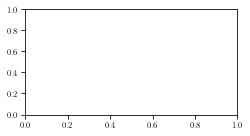

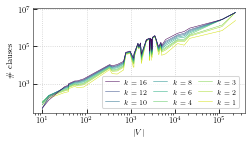

fig_width: 3.7800000000000002
fig_height: 1.8900000000000001


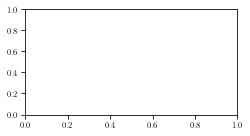

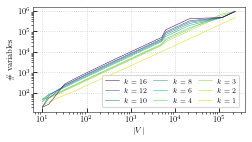

fig_width: 3.7800000000000002
fig_height: 1.8900000000000001


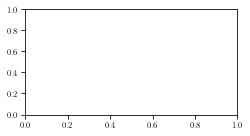

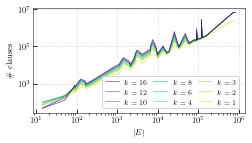

fig_width: 3.7800000000000002
fig_height: 1.8900000000000001


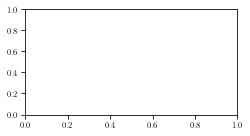

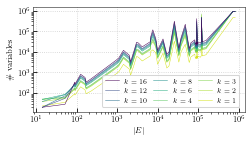

<Figure size 273.872x136.936 with 0 Axes>

In [14]:
def plot_model_size_vs_network_size(instances=None, network_size_param='n_nodes', model_size_param='n_clauses'):
    
    # Set up the figure
    correction = 1.12     # May need this to make the figures actually the right size
    fig_width = col_width_in * correction
    fig_height =  fig_width * 0.5
    tolatex.latexify(fig_width=fig_width, fig_height=fig_height, columns=column)
    plt.minorticks_off()
    fig, ax = plt.subplots(1, 1)

    cmap = plt.cm.get_cmap('viridis_r')
    fitting_data = []

    gis_enc_data_inst = gis_enc_data[gis_enc_data['benchmark'].isin(instances)].copy()
    gis_enc_data_inst = gis_enc_data[gis_enc_data[model_size_param].notna()]

    for k in sorted([int(k) for k in k_values]):
        k_data = gis_enc_data_inst[gis_enc_data_inst['k'] == k].copy()
        k_data.sort_values(network_size_param, inplace=True)
        network_sizes = k_data[network_size_param].to_list()
        model_sizes = k_data[model_size_param].to_list()

        ax.plot(network_sizes, model_sizes,
                color=cmap(k / 16.0), lw=0.5,
                label=r'$k = ' + str(k) + r'$')

    ax.xaxis.grid(color='0.8', linestyle=':')
    ax.yaxis.grid(color='0.8', linestyle=':')
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    if network_size_param == 'n_nodes':
        ax.set_xlabel(r'$|V|$')
    elif network_size_param == 'n_edges':
        ax.set_xlabel(r'$|E|$')
        
    if model_size_param == 'n_clauses':
        ax.set_ylabel(r'\# clauses')
    elif model_size_param == 'n_vars':
        ax.set_ylabel(r'\# variables')
        
    tolatex.format_axes(ax)

    handles, labels = ax.get_legend_handles_labels()
    if len(instances) > 10:
        ax.legend(handles[::-1], labels[::-1],
                  bbox_to_anchor=(0.65, 0.2),
                  loc='center',
                  fontsize=7,
                  ncol=3,
                  labelspacing=0.5,
                  columnspacing=0.8)
    else:
        ax.legend(handles[::-1], labels[::-1],
                  bbox_to_anchor=(0.65, 0.2),
                  loc='center',
                  fontsize=7,
                  ncol=3,
                  labelspacing=0.5,
                  columnspacing=0.8)

    fig_filename = f'{gis_enc_expid}_gis_{model_size_param}_vs_{network_size_param}_ijcai'
    plt.savefig(f"{fig_filename}.pdf", bbox_inches="tight")
    if save_png:
        plt.savefig(f"{fig_filename}.png", bbox_inches="tight", dpi=300)
    plt.show()
    plt.clf()
    
# This is Figure 2 in the main paper:
plot_model_size_vs_network_size(instances=relevant_networks, model_size_param='n_clauses', network_size_param='n_nodes')

# These are other figures that may be of interest:
plot_model_size_vs_network_size(instances=relevant_networks, model_size_param='n_vars', network_size_param='n_nodes')
plot_model_size_vs_network_size(instances=relevant_networks, model_size_param='n_clauses', network_size_param='n_edges')
plot_model_size_vs_network_size(instances=relevant_networks, model_size_param='n_vars', network_size_param='n_edges')

fig_width: 3.7800000000000002
fig_height: 1.8900000000000001


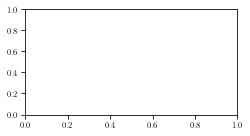

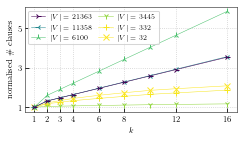

fig_width: 3.7800000000000002
fig_height: 1.8900000000000001


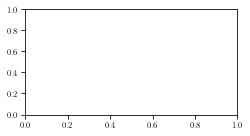

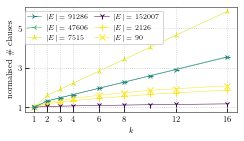

fig_width: 3.7800000000000002
fig_height: 1.8900000000000001


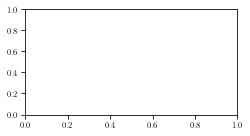

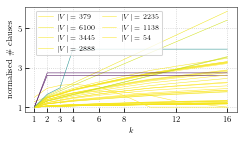

fig_width: 3.7800000000000002
fig_height: 1.8900000000000001


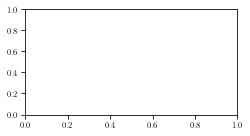

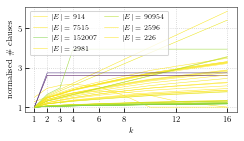

<Figure size 273.872x136.936 with 0 Axes>

In [15]:
def plot_model_size_vs_k(instances=None, size_param='n_nodes'):
    """Plot model sizes of ILP and GIS encoding as a function of k, 
    with either n_nodes or n_edges visualised in colour.

    Args:
        instances (list): A list of instances that we want to include in the plot.
        size_param (str): Choose from: {k, n_nodes, n_edges, median_degree}

    Returns:
        bool: The return value. True for success, False otherwise.

    """

    # Set up the figure
    
    correction = 1.12     # May need this to make the figures actually the right size
    fig_width = col_width_in * correction
    fig_height =  fig_width * 0.5
    tolatex.latexify(fig_width=fig_width, fig_height=fig_height, columns=column)
    plt.minorticks_off()
    fig, ax = plt.subplots(1, 1)
    
    cmap = plt.cm.get_cmap('viridis_r')
    markers = ['x', '+', '1', '2', '3', '4']
    
    # Extract extreme values
    max_n_csts = max(
        ilp_enc_data[ilp_enc_data['benchmark'].isin(instances)].n_csts.max(), 
        gis_enc_data[gis_enc_data['benchmark'].isin(instances)].n_clauses.max())
    max_n_vars = max(
        ilp_enc_data[ilp_enc_data['benchmark'].isin(instances)].n_vars.max(), 
        gis_enc_data[gis_enc_data['benchmark'].isin(instances)].n_vars.max())


    gis_enc_data.sort_values('n_nodes', inplace=True)
#     benchmarks = [b for b in enc_data_gis.benchmark.unique() if b in instances]
    
    gis_enc_data_inst = gis_enc_data[gis_enc_data['benchmark'].isin(instances)].copy()
    
    numbers_of_nodes = gis_enc_data_inst.n_nodes.unique()    
    numbers_of_edges = gis_enc_data_inst.n_edges.unique()
    
    max_n_nodes = max(numbers_of_nodes)
    min_n_nodes = min(numbers_of_nodes)
    
    max_n_edges = max(numbers_of_edges)
    
    for i, instance in enumerate(instances):
        this_inst_data = gis_enc_data_inst[gis_enc_data_inst['benchmark'] == instance].copy()
        if this_inst_data['n_clauses'].isnull().sum() == len(this_inst_data.index):
            continue
        this_inst_data.sort_values('k', inplace=True)
        k_values = this_inst_data['k'].to_list()
        n_clauses = this_inst_data['n_clauses'].to_list()
        n_nodes = this_inst_data['n_nodes'].unique()[0]
        n_edges = this_inst_data['n_edges'].unique()[0]
        scaled_n_clauses = [(1.0 * n_clause)/min(n_clauses) for n_clause in n_clauses]
        
        if size_param == 'n_nodes':            
            label=r'$|V| = ' + str(int(n_nodes)) + r'$'
            cmap_colour = n_nodes/max_n_nodes*1.0
        elif size_param == 'n_edges':
            label=r'$|E| = ' + str(int(n_edges)) + r'$'
            cmap_colour = n_edges/max_n_edges*1.0
            
        if len(instances) > 10:                
            ax.plot(k_values, scaled_n_clauses,
                    color=cmap(cmap_colour), lw=0.5,
                    label=label)
        else:
            ax.plot(k_values, scaled_n_clauses,
                    color=cmap(cmap_colour), lw=0.5,
                    label=label,
                    marker=markers[i % len(markers)])

    ax.xaxis.grid(color='0.8', linestyle=':')
    ax.yaxis.grid(color='0.8', linestyle=':')
    ax.set_xlabel(r'$k$')
    ax.set_xticks([1, 2, 3, 4, 6, 8, 12, 16])
    ax.set_yticks([1, 3, 5])
    ax.set_ylabel(r'normalised \# clauses')
    tolatex.format_axes(ax)

    handles, labels = ax.get_legend_handles_labels()
    if len(instances) > 10:
        ax.legend(handles[::-7], labels[::-7],
                  bbox_to_anchor=(0.35, 0.75),
                  loc='center',
                  fontsize=7,
                  ncol=2,
                  labelspacing=0.5,
                  columnspacing=0.8)
    else:
        ax.legend(handles[::-1], labels[::-1],
                  bbox_to_anchor=(0.325, 0.8),
                  loc='center',
                  fontsize=7,
                  ncol=2,
                  labelspacing=0.5,
                  columnspacing=0.8)
    figname = f"{gis_enc_expid}_norm-n_clauses-vs-k_colour-is-{size_param}_{len(instances)}-inst_ijcai"
    plt.savefig(f"{figname}.pdf", bbox_inches="tight")
    if save_png:
        plt.savefig(f"{figname}.png", bbox_inches="tight", dpi=300)
    plt.show()
    plt.clf()


instances = ['soccer_ball.txt',
             'inf-USAir97.mtx',
             'socfb-Pepperdine86.mtx',
             'ca-Erdos992.mtx',
             'web-indochina-2004.mtx',
             'ca-CondMat.mtx',
             ]

# This is Figure 3 in the main paper:
plot_model_size_vs_k(instances=instances, size_param='n_nodes')

# This is the same figure only we report the number of edges instead of the number of nodes:
plot_model_size_vs_k(instances=instances, size_param='n_edges')


# And here are the plots for all instances:
plot_model_size_vs_k(instances=relevant_networks, size_param='n_nodes')
plot_model_size_vs_k(instances=relevant_networks, size_param='n_edges')


## Solution quality

We now analyse the results on the instances that could be encoded into ILP, so we can report on the relative solution qualities of the GIS method and the ILP method (**Q4**).

In [16]:
def get_cardinality_ratios(instances=None, ilp_config='config1'):
    
    # Get data for relevant benchmarks:
    ilp_data_inst = ilp_data[(ilp_data['benchmark'].isin(instances)) & (ilp_data.ilp_configuration == ilp_config)].copy()
    gis_data_inst = gis_data[gis_data['benchmark'].isin(instances)].copy()
    
    cardinality_ratios = []
    for k in k_values:
        ilp_solved_instances = ilp_data_inst[(ilp_data_inst.k == int(k)) & (~ilp_data_inst.optimised_value.isna())].benchmark.unique()
        for instance in ilp_solved_instances:
            gis_opt_val = gis_data_inst[(gis_data_inst.k == int(k)) & (gis_data_inst.benchmark == instance)].optimised_value.tolist()[0]
            ilp_opt_val = ilp_data_inst[(ilp_data_inst.k == int(k)) & (ilp_data_inst.benchmark == instance)].optimised_value.tolist()[0]
            cardinality_ratio = (float(gis_opt_val)/2)/ilp_opt_val
            cardinality_ratios.append((k, instance, cardinality_ratio))
    cardinality_ratios.sort(key = lambda x: x[2])
    for elt in cardinality_ratios:
        print(elt)
    
get_cardinality_ratios(instances=relevant_networks)
    

('1', 'PhilippineAdj.txt', 1.0)
('2', 'ParisAdj.txt', 1.0)
('2', 'PhilippineAdj.txt', 1.0)
('3', 'road-chesapeake.mtx', 1.0)
('1', 'ca-netscience.mtx', 1.0164835164835164)
('2', 'MadridAdj.txt', 1.0555555555555556)
('1', 'MadridAdj.txt', 1.0588235294117647)
('2', 'ca-sandi_auths.mtx', 1.0655737704918034)
('1', 'ca-sandi_auths.mtx', 1.0731707317073171)
('3', 'PhilippineAdj.txt', 1.0769230769230769)
('4', 'PhilippineAdj.txt', 1.0769230769230769)
('6', 'PhilippineAdj.txt', 1.0769230769230769)
('8', 'PhilippineAdj.txt', 1.0769230769230769)
('10', 'PhilippineAdj.txt', 1.0769230769230769)
('12', 'PhilippineAdj.txt', 1.0769230769230769)
('16', 'PhilippineAdj.txt', 1.0769230769230769)
('2', 'soccer_ball.txt', 1.0833333333333333)
('2', 'soc-dolphins.mtx', 1.0857142857142856)
('2', 'road-chesapeake.mtx', 1.096774193548387)
('1', 'soccer_ball.txt', 1.1111111111111112)
('2', 'ZerkaniAdj.txt', 1.1153846153846154)
('3', 'ParisAdj.txt', 1.125)
('4', 'ParisAdj.txt', 1.125)
('1', 'power-494-bus.mtx', 1

## Details about benchmark set

We now generate Table 4 in the technical appendix. **Important**: make sure to run `scripts/collect_network_stats.py` first!

In [17]:
aggregated_data = []
for json_file in os.listdir(STATS_DIR):
    path_to_file = f'{STATS_DIR}/{json_file}'
    print(path_to_file)
    with gzip.open(path_to_file) as json_file:
        instance_data = json.loads(json_file.read())
        new_dict = {
            'network': instance_data['network'].replace('.gz', ''),
            'n_nodes': instance_data['n_nodes'],
            'n_edges': instance_data['n_edges'],
            'max_degree': instance_data['max_degree'],
            'med_degree': instance_data['med_degree'],
            'mean_degree': instance_data['mean_degree'],
            'mean_clustering': mean(instance_data['clustering'].values()),
            'mean_n_triangles': mean(instance_data['n_triangles'].values()),
        }
        aggregated_data.append(new_dict)
        data = pd.DataFrame(aggregated_data)

data = data[data['network'].isin(relevant_networks)].copy()
data.sort_values('n_nodes', inplace=True)
print(data)
data.to_csv('aggregated_network_stats_ijcai.csv')

compact_table_rows = []
for index, row in data.iterrows():
    compact_table_rows.append({
        'network': re.sub("\.(txt|mtx|edges)\.gz", "", row['network'], re.DOTALL).replace('_', '-'),
        '$|V|$': '$' + latexify_integer(row['n_nodes']) + '$',
        r'$|E|$': r'$' + latexify_integer(row['n_edges']) + r'$',
        r'$med(d)$': r'$' + latexify_integer(row['med_degree']) + r'$',
    })
compact_results = pd.DataFrame(compact_table_rows)
filename = f'network_stats_ijcai'
with open(f'{filename}.tex', 'w') as tf:
    tf.write(compact_results.to_latex(index=False, escape=False))
with open(f'{filename}_transposed.tex', 'w') as tf:
    tf.write(compact_results.transpose().to_latex(index=False, escape=False))

/media/anna/20cfa436-8389-4d19-8e23-3064f9df7fbb/experimental-data/identifying-codes/exp-data/network-stats/power-eris1176.mtx.gz
/media/anna/20cfa436-8389-4d19-8e23-3064f9df7fbb/experimental-data/identifying-codes/exp-data/network-stats/soc-dolphins.mtx.gz
/media/anna/20cfa436-8389-4d19-8e23-3064f9df7fbb/experimental-data/identifying-codes/exp-data/network-stats/ca-GrQc.mtx.gz
/media/anna/20cfa436-8389-4d19-8e23-3064f9df7fbb/experimental-data/identifying-codes/exp-data/network-stats/road-luxembourg-osm.mtx.gz
/media/anna/20cfa436-8389-4d19-8e23-3064f9df7fbb/experimental-data/identifying-codes/exp-data/network-stats/socfb-Bowdoin47.mtx.gz
/media/anna/20cfa436-8389-4d19-8e23-3064f9df7fbb/experimental-data/identifying-codes/exp-data/network-stats/ca-citeseer.mtx.gz
/media/anna/20cfa436-8389-4d19-8e23-3064f9df7fbb/experimental-data/identifying-codes/exp-data/network-stats/socfb-Wellesley22.mtx.gz
/media/anna/20cfa436-8389-4d19-8e23-3064f9df7fbb/experimental-data/identifying-codes/exp-data

/tmp/ipykernel_10835/2184545379.py:36: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tf.write(compact_results.to_latex(index=False, escape=False))
/tmp/ipykernel_10835/2184545379.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tf.write(compact_results.transpose().to_latex(index=False, escape=False))


## More plots

Here are some more plots that we can use to analyse our data, but which didn't make it to the paper or the technical appendix.

### Model size

We create the following types of plots:

- A square model size comparison with the number of clauses of the GIS encoding on one axis, and the number of constraints of the ILP encoding on the other. The colour indicates $k$, $|V|$, $|E|$, or median degree.
- Individual plots, where we compare the number of variables or the number of constraints/clauses for both encodings as a function of $k$ for each instance.
- Plots in which we plot the total number of constraint or clauses as a function of $k$, $|V|$, $|E|$ or median degree for each instance in one figure.

fig_width: 3.7800000000000002
fig_height: 3.7800000000000002


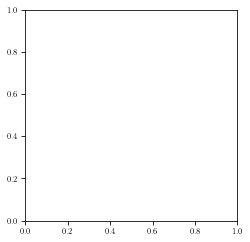

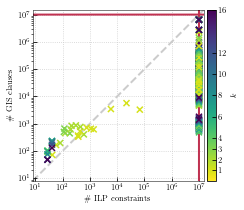

fig_width: 3.7800000000000002
fig_height: 3.7800000000000002
No data for road-roadNet-PA.mtx


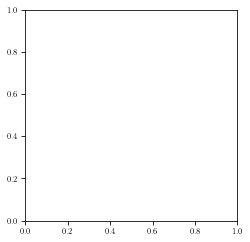

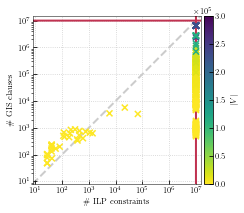

fig_width: 3.7800000000000002
fig_height: 3.7800000000000002
No data for road-roadNet-PA.mtx


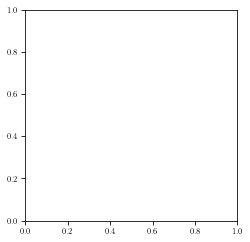

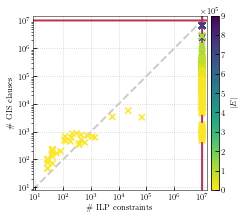

fig_width: 3.7800000000000002
fig_height: 3.7800000000000002


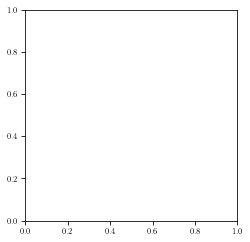

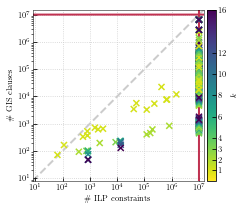

fig_width: 3.7800000000000002
fig_height: 3.7800000000000002
No data for road-roadNet-PA.mtx


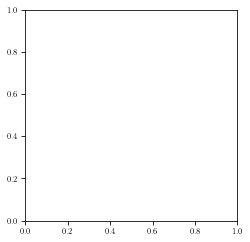

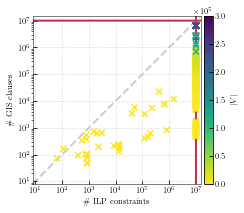

fig_width: 3.7800000000000002
fig_height: 3.7800000000000002
No data for road-roadNet-PA.mtx


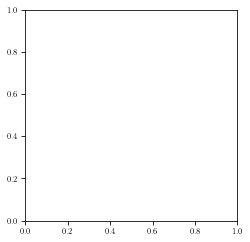

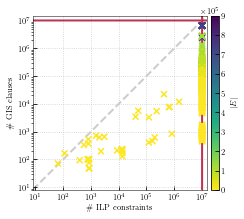

<Figure size 273.872x273.872 with 0 Axes>

In [18]:
def plot_enc_size_square(instances=None, size_param='k', ilp_config='config1'):
    """Plot model sizes of ILP and GIS encoding, with k, n_nodes, n_edges, or median degree visualised in colour.

    Args:
        instances (list): A list of instances that we want to include in the plot.
        size_param (str): Choose from: {k, n_nodes, n_edges, median_degree}

    Returns:
        bool: The return value. True for success, False otherwise.

    """

    # Set up the figure
    
    correction = 1.12     # May need this to make the figures actually the right size
    fig_width = col_width_in * correction
    tolatex.latexify(fig_width=fig_width, fig_height=fig_width, columns=column)
    plt.minorticks_off()
    fig, ax = plt.subplots(1, 1)
    cm = plt.cm.get_cmap('viridis_r')

    # Extract extreme values
    max_size = max(
        ilp_enc_data[ilp_enc_data['benchmark'].isin(instances)].n_csts.max(), 
        gis_enc_data[gis_enc_data['benchmark'].isin(instances)].n_clauses.max())
    
    number, zeros = get_upper_bound(max_size)
    fail_size = ceil(number/10.0) * 10**(zeros+1)
    
    max_colour = max(
        ilp_enc_data[ilp_enc_data['benchmark'].isin(instances)][size_param].max(), 
        gis_enc_data[gis_enc_data['benchmark'].isin(instances)][size_param].max())
    
    if size_param in ['n_nodes', 'n_edges']:
        number, zeros = get_upper_bound(max_colour)
        colour_ub = number * 10**(zeros)
    elif size_param == 'k':
        colour_ub = 16
    
    for instance in instances:
        ilp_enc_data_inst = ilp_enc_data[
            (ilp_enc_data['benchmark'] == instance) &
            (ilp_enc_data['ilp_configuration'] == ilp_config)].copy()
        gis_enc_data_inst = gis_enc_data[
            (gis_enc_data['benchmark'] == instance)].copy()
        

        # Update values for time out:
        ilp_enc_data_inst.n_csts = ilp_enc_data_inst.n_csts.replace(np.nan, fail_size)

        # Sort values by k (not really necessary)
        ilp_enc_data_inst.sort_values('k', inplace=True)
        gis_enc_data_inst.sort_values('k', inplace=True)

        if gis_enc_data_inst.empty:
            print(f"No data for {instance}")
            continue

        # Extract k values, number of clauses, number of variables
        X_ilp = ilp_enc_data_inst['n_csts'].tolist()
        Y_gis = gis_enc_data_inst['n_clauses'].tolist()
        Z = gis_enc_data_inst[size_param].tolist()
        
        if np.isnan(Z[0]):
            print(f"No data for {instance}")
            continue

        # Plot
        sc = ax.scatter(X_ilp, Y_gis, c=Z, marker='x', vmin=0, vmax=colour_ub, cmap=cm, zorder=3)

    diag_X = range(0, int(fail_size * 10.3), 100)
    diag_Y = diag_X
    ax.plot(diag_X, diag_Y, '--', color='0.8', lw=2, zorder=1)

    timeout_var = range(0, int(fail_size * 10.3), 100)
    timeout_const = [fail_size] * len(timeout_var)
    ax.plot(timeout_var, timeout_const, '-', color=style['fail']['c'], lw=2, zorder=2)
    ax.plot(timeout_const, timeout_var, '-', color=style['fail']['c'], lw=2, zorder=2)


    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('\# ILP constraints', fontsize=8)
    ax.set_ylabel('\# GIS clauses', fontsize=8)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.xaxis.grid(color='0.8', linestyle=':')
    ax.yaxis.grid(color='0.8', linestyle=':')
    plt.xlim([8, fail_size * 1.5])
    plt.ylim([8, fail_size * 1.5])
    ax.set_xticks([x for x in [10, 100, 1000, 10000, 100000, 1000000, 10000000] if x < fail_size*10.3])
    ax.set_yticks([x for x in [10, 100, 1000, 10000, 100000, 1000000, 10000000] if x < fail_size*10.3])
    tolatex.format_axes(ax)
    
    # create an axis on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    tolatex.format_axes(cax)

    cbar = fig.colorbar(sc, cax=cax)
    cbar_label = ''
    if size_param == 'k':
        cbar_label = '$k$'
    elif size_param == 'n_nodes':
        cbar_label = '$|V|$'
    elif size_param == 'n_edges':
        cbar_label = '$|E|$'
     
    if size_param in ['n_nodes', 'n_edges']:
        cbar.formatter.set_powerlimits((0, 0))
        cbar.ax.yaxis.set_offset_position('right')                         
        cbar.update_ticks()
    elif size_param == 'k':
        cbar.set_ticks(sorted(gis_enc_data.k.unique()))
    
    cbar.set_label(cbar_label)

    fig.tight_layout()
    figname = f"{ilp_enc_expid}_{gis_enc_expid}_ilp-{ilp_config}_model-size-vs-{size_param}_square_ijcai"
    plt.savefig(f"{figname}.pdf", bbox_inches="tight")
    if save_png:
        plt.savefig(f"{figname}.png", bbox_inches="tight", dpi=300)
    plt.show()
    plt.clf()

instances = relevant_networks
plot_enc_size_square(instances=instances, size_param='k', ilp_config='config1')
plot_enc_size_square(instances=instances, size_param='n_nodes', ilp_config='config1')
plot_enc_size_square(instances=instances, size_param='n_edges', ilp_config='config1')
plot_enc_size_square(instances=instances, size_param='k', ilp_config='config0')
plot_enc_size_square(instances=instances, size_param='n_nodes', ilp_config='config0')
plot_enc_size_square(instances=instances, size_param='n_edges', ilp_config='config0')

fig_width: 3.7800000000000002
fig_height: 3.7800000000000002


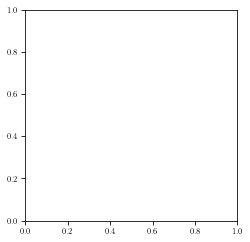

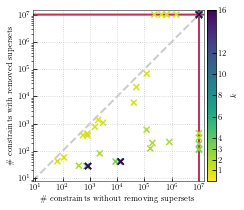

fig_width: 3.7800000000000002
fig_height: 3.7800000000000002
No data for socfb-Caltech36.mtx
No data for socfb-Reed98.mtx
No data for socfb-Haverford76.mtx
No data for socfb-Simmons81.mtx
No data for socfb-Swarthmore42.mtx
No data for socfb-Amherst41.mtx
No data for socfb-Bowdoin47.mtx
No data for socfb-Hamilton46.mtx
No data for socfb-Trinity100.mtx
No data for road-minnesota.mtx
No data for socfb-USFCA72.mtx
No data for socfb-Williams40.mtx
No data for socfb-nips-ego.edges
No data for socfb-Oberlin44.mtx
No data for socfb-Smith60.mtx
No data for socfb-Wellesley22.mtx
No data for web-edu.mtx
No data for socfb-Vassar85.mtx
No data for socfb-Middlebury45.mtx
No data for socfb-Pepperdine86.mtx
No data for socfb-Colgate88.mtx
No data for socfb-Mich67.mtx
No data for ca-GrQc.mtx
No data for web-EPA.edges
No data for web-spam.mtx
No data for power-US-Grid.mtx
No data for ca-Erdos992.mtx
No data for web-indochina-2004.mtx
No data for web-webbase-2001.mtx
No data for ca-CondMat.mtx
No data fo

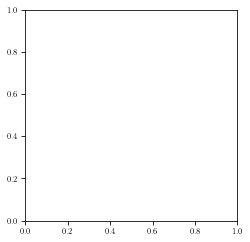

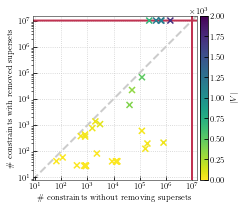

fig_width: 3.7800000000000002
fig_height: 3.7800000000000002
No data for socfb-Caltech36.mtx
No data for socfb-Reed98.mtx
No data for socfb-Haverford76.mtx
No data for socfb-Simmons81.mtx
No data for socfb-Swarthmore42.mtx
No data for socfb-Amherst41.mtx
No data for socfb-Bowdoin47.mtx
No data for socfb-Hamilton46.mtx
No data for socfb-Trinity100.mtx
No data for road-minnesota.mtx
No data for socfb-USFCA72.mtx
No data for socfb-Williams40.mtx
No data for socfb-nips-ego.edges
No data for socfb-Oberlin44.mtx
No data for socfb-Smith60.mtx
No data for socfb-Wellesley22.mtx
No data for web-edu.mtx
No data for socfb-Vassar85.mtx
No data for socfb-Middlebury45.mtx
No data for socfb-Pepperdine86.mtx
No data for socfb-Colgate88.mtx
No data for socfb-Mich67.mtx
No data for ca-GrQc.mtx
No data for web-EPA.edges
No data for web-spam.mtx
No data for power-US-Grid.mtx
No data for ca-Erdos992.mtx
No data for web-indochina-2004.mtx
No data for web-webbase-2001.mtx
No data for ca-CondMat.mtx
No data fo

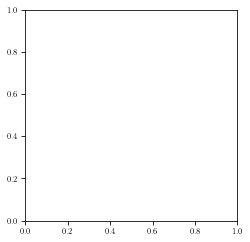

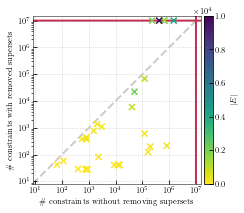

<Figure size 273.872x273.872 with 0 Axes>

In [19]:
def plot_ilp_enc_size_square(instances=None, size_param='k'):

    # Set up the figure
    
    correction = 1.12     # May need this to make the figures actually the right size
    fig_width = col_width_in * correction
    tolatex.latexify(fig_width=fig_width, fig_height=fig_width, columns=column)
    plt.minorticks_off()
    fig, ax = plt.subplots(1, 1)
    cm = plt.cm.get_cmap('viridis_r')

    # Extract extreme values
    max_size = ilp_enc_data[ilp_enc_data['benchmark'].isin(instances)].n_csts.max()
    
    number, zeros = get_upper_bound(max_size)
    fail_size = ceil(number/10.0) * 10**(zeros+1)
    
    max_colour = ilp_enc_data[ilp_enc_data['benchmark'].isin(instances)][size_param].max()
    
    if size_param in ['n_nodes', 'n_edges']:
        number, zeros = get_upper_bound(max_colour)
        colour_ub = number * 10**(zeros)
    elif size_param == 'k':
        colour_ub = 16
    
    for instance in instances:
        ilp_enc_data_inst_config0 = ilp_enc_data[
            (ilp_enc_data['benchmark'] == instance) &
            (ilp_enc_data['ilp_configuration'] == 'config0')].copy()
        ilp_enc_data_inst_config1 = ilp_enc_data[
            (ilp_enc_data['benchmark'] == instance) &
            (ilp_enc_data['ilp_configuration'] == 'config1')].copy()
        

        # Update values for time out:
        ilp_enc_data_inst_config0.n_csts = ilp_enc_data_inst_config0.n_csts.replace(np.nan, fail_size)
        ilp_enc_data_inst_config1.n_csts = ilp_enc_data_inst_config1.n_csts.replace(np.nan, fail_size)

        # Sort values by k (not really necessary)
        ilp_enc_data_inst_config0.sort_values('k', inplace=True)
        ilp_enc_data_inst_config1.sort_values('k', inplace=True)
        
#         if gis_enc_data_inst.empty:
#             print(f"No data for {instance}")
#             continue

        # Extract k values, number of clauses, number of variables
        X_config0 = ilp_enc_data_inst_config0['n_csts'].tolist()
        Y_config1 = ilp_enc_data_inst_config1['n_csts'].tolist()
        Z = ilp_enc_data_inst_config0[size_param].tolist()
        
        if np.isnan(Z[0]):
            print(f"No data for {instance}")
            continue

        # Plot
        sc = ax.scatter(X_config0, Y_config1, c=Z, marker='x', vmin=0, vmax=colour_ub, cmap=cm, zorder=3)

    diag_X = range(0, int(fail_size * 10.3), 100)
    diag_Y = diag_X
    ax.plot(diag_X, diag_Y, '--', color='0.8', lw=2, zorder=1)

    timeout_var = range(0, int(fail_size * 10.3), 100)
    timeout_const = [fail_size] * len(timeout_var)
    ax.plot(timeout_var, timeout_const, '-', color=style['fail']['c'], lw=2, zorder=2)
    ax.plot(timeout_const, timeout_var, '-', color=style['fail']['c'], lw=2, zorder=2)


    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('\# constraints without removing supersets', fontsize=8)
    ax.set_ylabel('\# constraints with removed supersets', fontsize=8)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.xaxis.grid(color='0.8', linestyle=':')
    ax.yaxis.grid(color='0.8', linestyle=':')
    plt.xlim([8, fail_size * 1.5])
    plt.ylim([8, fail_size * 1.5])
    ax.set_xticks([x for x in [10, 100, 1000, 10000, 100000, 1000000, 10000000] if x < fail_size*10.3])
    ax.set_yticks([x for x in [10, 100, 1000, 10000, 100000, 1000000, 10000000] if x < fail_size*10.3])
    tolatex.format_axes(ax)
    
    # create an axis on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    tolatex.format_axes(cax)

    cbar = fig.colorbar(sc, cax=cax)
    cbar_label = ''
    if size_param == 'k':
        cbar_label = '$k$'
    elif size_param == 'n_nodes':
        cbar_label = '$|V|$'
    elif size_param == 'n_edges':
        cbar_label = '$|E|$'
     
    if size_param in ['n_nodes', 'n_edges']:
        cbar.formatter.set_powerlimits((0, 0))
        cbar.ax.yaxis.set_offset_position('right')                         
        cbar.update_ticks()
    elif size_param == 'k':
        cbar.set_ticks(sorted(gis_enc_data.k.unique()))
    
    cbar.set_label(cbar_label)

    fig.tight_layout()
    figname = f"{ilp_enc_expid}_model-size-comparison_configs_{size_param}_square_ijcai"
    plt.savefig(f"{figname}.pdf", bbox_inches="tight")
    if save_png:
        plt.savefig(f"{figname}.png", bbox_inches="tight", dpi=300)
    plt.show()
    plt.clf()

instances = relevant_networks
plot_ilp_enc_size_square(instances=instances, size_param='k')
plot_ilp_enc_size_square(instances=instances, size_param='n_nodes')
plot_ilp_enc_size_square(instances=instances, size_param='n_edges')

In [1]:
def plot_model_size_vs_k_gis(instances=None):

    n_instances = len(instances)
    n_cols = 3
    n_rows = ceil(n_instances / float(n_cols))
    max_n_rows = 5
    num_figs = ceil(n_rows / float(max_n_rows))
    rows_plotted = 0
    
    instance_id = 0
    
    for fig_idx in range(num_figs):
        n_rows_in_this_fig = min(max_n_rows, n_rows - rows_plotted)
        fig_width = 2*col_width_in + col_gap_in
        fig_height = fig_width * 0.25 * n_rows_in_this_fig

        tolatex.latexify(fig_width=fig_width, fig_height=fig_height, columns=column)
        plt.minorticks_off()

        fig, axes = plt.subplots(n_rows_in_this_fig, n_cols)
        plt.subplots_adjust(hspace=0.1)
        plt.subplots_adjust(wspace=0.1)

        for row in axes:
            for col in row:
                if instance_id >= n_instances:
                    break
                instance = instances[instance_id]
                instance_id += 1
                print(instance)
                gis_enc_data_inst = gis_enc_data[(gis_enc_data['benchmark'] == instance)].copy()
                gis_enc_data_inst.sort_values('k', inplace=True)

                if gis_enc_data_inst.empty:
                    print(f"No data for {instance}")
                    continue
                n_nodes = gis_enc_data_inst.n_nodes.unique()[0]
                if np.isnan(n_nodes):
                    print(f"No data for {instance}")
                    continue

                # Extract k values, number of clauses, number of variables
                X = gis_enc_data_inst['k'].tolist()
                Y_clauses = gis_enc_data_inst['n_clauses'].tolist()
                Y_vars = gis_enc_data_inst['n_vars'].tolist()

                # Plot
                col.plot(X, Y_clauses, lw=1,
                         ls=style['gis-clss']['ls'],
                         marker=style['gis-clss']['m'],
                         color=style['gis-clss']['c'])
                
                col2 = col.twinx() 
                col2.plot(X, Y_vars, lw=1,
                         ls=style['gis-vars']['ls'],
                         marker=style['gis-vars']['m'],
                         color=style['gis-vars']['c'])

                # Annotations
                col.set_title(re.sub('\.gz|\.mtx|\.edges|\.txt', '', instance), fontsize=8)
                col.set_xlabel('$k$', fontsize=8)
                col.set_ylabel('\# clauses', fontsize=8)
                col.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
                col.xaxis.set_ticks([int(k) for k in k_values])
                
                col2.set_ylabel('\# variables', fontsize=8)
                col2.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

                col.text(0.95, 0.1, '$|V|$ = ' + latexify_integer(int(n_nodes)),
                         transform=col.transAxes,
                         horizontalalignment='right', fontsize=8)
                tolatex.format_axes(col)
                

            rows_plotted += 1
            
        labels = ['\# clauses in CNF encoding',
                  '\# variables in CNF encoding']
        leg_elts = [
            (Line2D([0], [0], label=labels[1], lw=1,
                         ls=style['gis-clss']['ls'],
                         marker=style['gis-clss']['m'],
                         color=style['gis-clss']['c'])),
            (Line2D([0], [0], label=labels[0], lw=1,
                         ls=style['gis-vars']['ls'],
                         marker=style['gis-vars']['m'],
                         color=style['gis-vars']['c']))
        ]
        leg = Legend(fig, handles=leg_elts, labels=labels,
                     bbox_to_anchor=(0.5, 0.9175), loc='center', ncol=2, fontsize=8, framealpha=0)
        fig.add_artist(leg)
        
        fig.suptitle("Model sizes {\sc gismo}", fontsize=14)

        fig.tight_layout()
        figname = f'{gis_enc_expid}_{gis_sol_expid}_n-clauses-and_n-variables-vs-k_{n_instances}-instances_fig{fig_idx}'
        fig.savefig(f"{figname}.pdf", bbox_inches="tight")
        if save_png:
            fig.savefig(f"{figname}.png", bbox_inches="tight", dpi=300)
        plt.clf()
    
plot_model_size_vs_k_gis(instances=relevant_networks)

NameError: name 'relevant_networks' is not defined

### Solving Time Comparison

fig_width: 3.7800000000000002
fig_height: 3.7800000000000002
ParisAdj.txt
PhilippineAdj.txt
ca-sandi_auths.mtx
soccer_ball.txt
ZerkaniAdj.txt
road-chesapeake.mtx
MadridAdj.txt
soc-dolphins.mtx
inf-USAir97.mtx
power-494-bus.mtx
power-685-bus.mtx
socfb-Caltech36.mtx
socfb-Reed98.mtx
power-1138-bus.mtx
road-euroroad.edges
power-eris1176.mtx
socfb-Haverford76.mtx
socfb-Simmons81.mtx
socfb-Swarthmore42.mtx
power-bcspwr09.mtx
socfb-Amherst41.mtx
socfb-Bowdoin47.mtx
socfb-Hamilton46.mtx
socfb-Trinity100.mtx
road-minnesota.mtx
socfb-USFCA72.mtx
socfb-Williams40.mtx
socfb-nips-ego.edges
socfb-Oberlin44.mtx
socfb-Smith60.mtx
socfb-Wellesley22.mtx
web-edu.mtx
socfb-Vassar85.mtx
socfb-Middlebury45.mtx
socfb-Pepperdine86.mtx
socfb-Colgate88.mtx
socfb-Mich67.mtx
ca-GrQc.mtx
web-EPA.edges
web-spam.mtx
power-US-Grid.mtx
ca-Erdos992.mtx
web-indochina-2004.mtx
web-webbase-2001.mtx
ca-CondMat.mtx
ca-citeseer.mtx
ca-dblp-2010.mtx
road-luxembourg-osm.mtx
road-roadNet-PA.mtx
ca-netscience.mtx


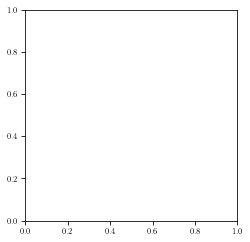

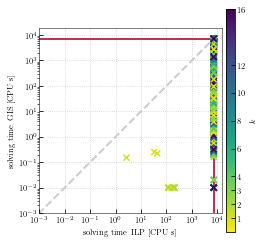

fig_width: 3.7800000000000002
fig_height: 3.7800000000000002
ParisAdj.txt
PhilippineAdj.txt
ca-sandi_auths.mtx
soccer_ball.txt
ZerkaniAdj.txt
road-chesapeake.mtx
MadridAdj.txt
soc-dolphins.mtx
inf-USAir97.mtx
power-494-bus.mtx
power-685-bus.mtx
socfb-Caltech36.mtx
socfb-Reed98.mtx
power-1138-bus.mtx
road-euroroad.edges
power-eris1176.mtx
socfb-Haverford76.mtx
socfb-Simmons81.mtx
socfb-Swarthmore42.mtx
power-bcspwr09.mtx
socfb-Amherst41.mtx
socfb-Bowdoin47.mtx
socfb-Hamilton46.mtx
socfb-Trinity100.mtx
road-minnesota.mtx
socfb-USFCA72.mtx
socfb-Williams40.mtx
socfb-nips-ego.edges
socfb-Oberlin44.mtx
socfb-Smith60.mtx
socfb-Wellesley22.mtx
web-edu.mtx
socfb-Vassar85.mtx
socfb-Middlebury45.mtx
socfb-Pepperdine86.mtx
socfb-Colgate88.mtx
socfb-Mich67.mtx
ca-GrQc.mtx
web-EPA.edges
web-spam.mtx
power-US-Grid.mtx
ca-Erdos992.mtx
web-indochina-2004.mtx
web-webbase-2001.mtx
ca-CondMat.mtx
ca-citeseer.mtx
ca-dblp-2010.mtx
road-luxembourg-osm.mtx
road-roadNet-PA.mtx
No data for road-roadNet-PA.mtx.

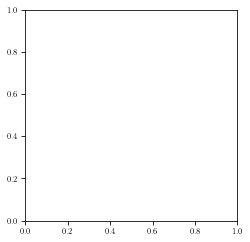

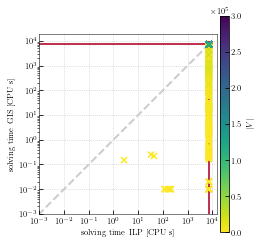

fig_width: 3.7800000000000002
fig_height: 3.7800000000000002
ParisAdj.txt
PhilippineAdj.txt
ca-sandi_auths.mtx
soccer_ball.txt
ZerkaniAdj.txt
road-chesapeake.mtx
MadridAdj.txt
soc-dolphins.mtx
inf-USAir97.mtx
power-494-bus.mtx
power-685-bus.mtx
socfb-Caltech36.mtx
socfb-Reed98.mtx
power-1138-bus.mtx
road-euroroad.edges
power-eris1176.mtx
socfb-Haverford76.mtx
socfb-Simmons81.mtx
socfb-Swarthmore42.mtx
power-bcspwr09.mtx
socfb-Amherst41.mtx
socfb-Bowdoin47.mtx
socfb-Hamilton46.mtx
socfb-Trinity100.mtx
road-minnesota.mtx
socfb-USFCA72.mtx
socfb-Williams40.mtx
socfb-nips-ego.edges
socfb-Oberlin44.mtx
socfb-Smith60.mtx
socfb-Wellesley22.mtx
web-edu.mtx
socfb-Vassar85.mtx
socfb-Middlebury45.mtx
socfb-Pepperdine86.mtx
socfb-Colgate88.mtx
socfb-Mich67.mtx
ca-GrQc.mtx
web-EPA.edges
web-spam.mtx
power-US-Grid.mtx
ca-Erdos992.mtx
web-indochina-2004.mtx
web-webbase-2001.mtx
ca-CondMat.mtx
ca-citeseer.mtx
ca-dblp-2010.mtx
road-luxembourg-osm.mtx
road-roadNet-PA.mtx
No data for road-roadNet-PA.mtx.

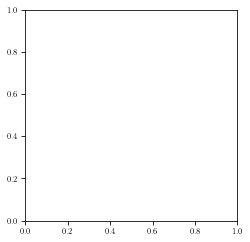

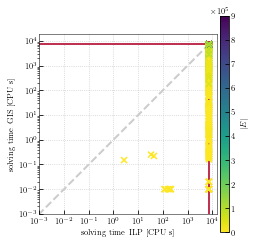

fig_width: 3.7800000000000002
fig_height: 3.7800000000000002


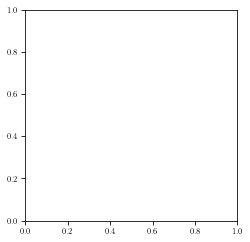

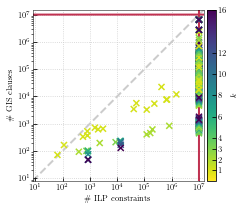

fig_width: 3.7800000000000002
fig_height: 3.7800000000000002
No data for road-roadNet-PA.mtx


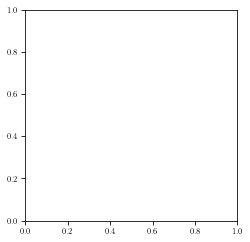

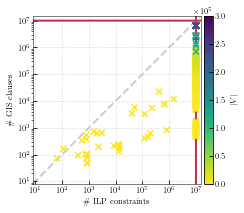

fig_width: 3.7800000000000002
fig_height: 3.7800000000000002
No data for road-roadNet-PA.mtx


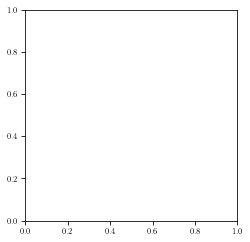

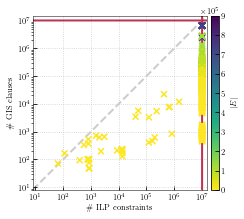

<Figure size 273.872x273.872 with 0 Axes>

In [21]:
def plot_solving_time_square(instances=None, size_param='k', ilp_config='config1'):
    """Plot solving times for ILP and GIS method, with k, n_nodes, n_edges, or median degree visualised in colour.

    Args:
        instances (list): A list of instances that we want to include in the plot.
        size_param (str): Choose from: {k, n_nodes, n_edges, median_degree}
        ilp_config (str): Choose from: {config0, config1}

    """

    # Set up the figure
    
    correction = 1.12     # May need this to make the figures actually the right size
    fig_width = col_width_in * correction
    tolatex.latexify(fig_width=fig_width, fig_height=fig_width, columns=column)
    plt.minorticks_off()
    fig, ax = plt.subplots(1, 1)
    cm = plt.cm.get_cmap('viridis_r')

    # Extract extreme values    
    max_colour = max(
        ilp_enc_data[ilp_enc_data['benchmark'].isin(instances)][size_param].max(), 
        gis_enc_data[gis_enc_data['benchmark'].isin(instances)][size_param].max())
    
    if size_param in ['n_nodes', 'n_edges']:
        number, zeros = get_upper_bound(max_colour)
        colour_ub = number * 10**(zeros)
    elif size_param == 'k':
        colour_ub = 16

    for instance in instances:
        print(instance)
        ilp_data_inst = ilp_data[
            (ilp_data['benchmark'] == instance) &
            (ilp_data['ilp_configuration'] == ilp_config)].copy()
        gis_data_inst = gis_data[
            (gis_data['benchmark'] == instance)].copy()        
        
        # Update values of failure:
        ilp_data_inst.utime_solve = np.where(
            (ilp_data_inst.n_vars.isna()) | (ilp_data_inst.optimised_value.isna()),
            sol_timeout, ilp_data_inst.utime_solve)
        gis_data_inst.utime_solve = np.where(
            (gis_data_inst.n_vars.isna()) | (gis_data_inst.optimised_value < 0),
            sol_timeout, gis_data_inst.utime_solve)

        # Sort values by k
        ilp_data_inst.sort_values('k', inplace=True)
        gis_data_inst.sort_values('k', inplace=True)


        # Extract k values, number of clauses, number of variables
        X_ilp = ilp_data_inst['utime_solve'].tolist() 
        Y_gis = gis_data_inst['utime_solve'].tolist()
        Z = gis_data_inst[size_param].tolist()
        
        if np.isnan(Z[0]):
            print(f"No data for {instance}.")
            continue

        # Plot
        sc = ax.scatter(X_ilp, Y_gis, c=Z, marker='x', vmin=0, vmax=colour_ub, cmap=cm, zorder=3)

    diag_X = range(0, int(sol_timeout * 1.3), 100)
    diag_Y = diag_X
    ax.plot(diag_X, diag_Y, '--', color='0.8', lw=2, zorder=1)

    timeout_var = range(0, int(sol_timeout * 1.3), 100)
    timeout_const = [sol_timeout] * len(timeout_var)
    ax.plot(timeout_var, timeout_const, '-', color=style['fail']['c'], lw=2, zorder=2)
    ax.plot(timeout_const, timeout_var, '-', color=style['fail']['c'], lw=2, zorder=2)

    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('solving time ILP [CPU s]', fontsize=8)
    ax.set_ylabel('solving time GIS [CPU s]', fontsize=8)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.xaxis.grid(color='0.8', linestyle=':')
    ax.yaxis.grid(color='0.8', linestyle=':')
    plt.xlim([8, sol_timeout * 1.05])
    plt.ylim([8, sol_timeout * 1.05])
    ax.set_xticks([x for x in [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000] if x < sol_timeout*10.3])
    ax.set_yticks([x for x in [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000] if x < sol_timeout*10.3])
    tolatex.format_axes(ax)
    tolatex.format_axes(cax)

    cbar = fig.colorbar(sc, cax=cax)
    cbar_label = ''
    if size_param == 'k':
        cbar_label = '$k$'
    elif size_param == 'n_nodes':
        cbar_label = '$|V|$'
    elif size_param == 'n_edges':
        cbar_label = '$|E|$'
     
    if size_param in ['n_nodes', 'n_edges']:
        cbar.formatter.set_powerlimits((0, 0))
        cbar.ax.yaxis.set_offset_position('right')                         
        cbar.update_ticks()
    elif size_param == 'k':
        cbar.set_ticks(sorted(gis_enc_data.k.unique()))
    
    cbar.set_label(cbar_label)
    fig.tight_layout()
    figname = f"{ilp_enc_expid}_{gis_enc_expid}_solving-time-vs-{size_param}_ilp-{ilp_config}_square_ijcai"
    plt.savefig(f"{figname}.pdf", bbox_inches="tight")
    if save_png:
        plt.savefig(f"{figname}.png", bbox_inches="tight", dpi=300)
    plt.show()
    plt.clf()

# instances = ilp_enc_data.benchmark.unique()
instances = relevant_networks
plot_solving_time_square(instances=instances, size_param='k', ilp_config='config1')
plot_solving_time_square(instances=instances, size_param='n_nodes', ilp_config='config1')
plot_solving_time_square(instances=instances, size_param='n_edges', ilp_config='config1')
plot_enc_size_square(instances=instances, size_param='k', ilp_config='config0')
plot_enc_size_square(instances=instances, size_param='n_nodes', ilp_config='config0')
plot_enc_size_square(instances=instances, size_param='n_edges', ilp_config='config0')

fig_width: 3.7800000000000002
fig_height: 1.8900000000000001


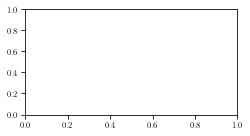

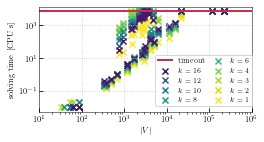

fig_width: 3.7800000000000002
fig_height: 1.8900000000000001


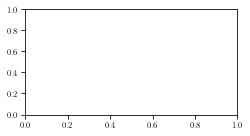

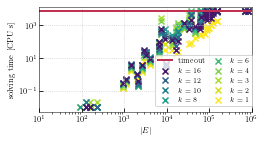

<Figure size 273.872x136.936 with 0 Axes>

In [25]:
def plot_solving_time_vs_network_size(instances=None, network_size_param='n_nodes'):
    
    # Set up the figure
    correction = 1.12     # May need this to make the figures actually the right size
    fig_width = col_width_in * correction
    fig_height =  fig_width * 0.5
    tolatex.latexify(fig_width=fig_width, fig_height=fig_height, columns=column)
    plt.minorticks_off()
    fig, ax = plt.subplots(1, 1)

    cmap = plt.cm.get_cmap('viridis_r')

    gis_data_inst = gis_data[(gis_data.benchmark.isin(instances))]

    gis_data_inst.utime_solve = np.where(
        (gis_data_inst.n_vars.isna()) | (gis_data_inst.optimised_value < 0),
        sol_timeout, gis_data_inst.utime_solve)

    for k in sorted([int(k) for k in k_values]):
        k_data = gis_data_inst[gis_data_inst['k'] == k].copy()
        k_data.sort_values(network_size_param, inplace=True)
        network_sizes = k_data[network_size_param].to_list()
        solving_times = k_data.utime_solve.to_list()

#         ax.plot(network_sizes, solving_times,
#                 color=cmap(k / 16.0), lw=0.5,
#                 label=r'$k = ' + str(k) + r'$')
        ax.scatter(network_sizes, solving_times,
                color=cmap((k-1) / 16.0), marker='x',
                label=r'$k = ' + str(k) + r'$')
    max_size = gis_data_inst[network_size_param].max()
    x_timeout = range(10, int(10 * max_size), int(max_size/20))
    y_timeout = [sol_timeout] * len(x_timeout)
    ax.plot(x_timeout, y_timeout, lw=2, c=c_timeout, label='timeout')
    
    ax.xaxis.grid(color='0.8', linestyle=':')
    ax.yaxis.grid(color='0.8', linestyle=':')
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xticks([x for x in [10, 100, 1000, 10000, 100000, 1000000] if x < max_size*10.3])
    ax.set_xlim((10, 1000000))
    
    if network_size_param == 'n_nodes':
        ax.set_xlabel(r'$|V|$')
    elif network_size_param == 'n_edges':
        ax.set_xlabel(r'$|E|$')
        
    ax.set_ylabel(r'solving time [CPU s]')
        
    tolatex.format_axes(ax)

    handles, labels = ax.get_legend_handles_labels()
    if len(instances) > 10:
        ax.legend(handles[::-1], labels[::-1],
                  bbox_to_anchor=(0.775, 0.3),
                  loc='center',
                  fontsize=7,
                  ncol=2,
                  labelspacing=0.5,
                  columnspacing=0.8)
    else:
        ax.legend(handles[::-1], labels[::-1],
                  bbox_to_anchor=(0.75, 0.3),
                  loc='center',
                  fontsize=7,
                  ncol=2,
                  labelspacing=0.5,
                  columnspacing=0.8)

    fig_filename = f'{gis_enc_expid}_gis_solving-time_vs_{network_size_param}_ijcai'
    plt.savefig(f"{fig_filename}.pdf", bbox_inches="tight")
    if save_png:
        plt.savefig(f"{fig_filename}.png", bbox_inches="tight", dpi=300)
    plt.show()
    plt.clf()
    
instances = gis_enc_data.benchmark.unique()
plot_solving_time_vs_network_size(instances=instances, network_size_param='n_nodes')
plot_solving_time_vs_network_size(instances=instances, network_size_param='n_edges')

fig_width: 3.7800000000000002
fig_height: 1.8900000000000001


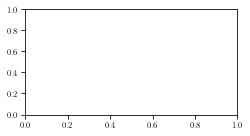

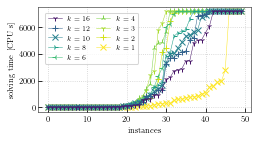

<Figure size 273.872x136.936 with 0 Axes>

In [26]:
def solving_cactus_plots(instances=None):
    
    # Set up the figure
    correction = 1.12     # May need this to make the figures actually the right size
    fig_width = col_width_in * correction
    fig_height =  fig_width * 0.5
    tolatex.latexify(fig_width=fig_width, fig_height=fig_height, columns=column)
    plt.minorticks_off()
    fig, ax = plt.subplots(1, 1)

    cmap = plt.cm.get_cmap('viridis_r')
    markers = ['x', '+', '1', '2', '3', '4']
    
    gis_data_inst = gis_data[(gis_data.benchmark.isin(instances))]

    gis_data_inst.utime_solve = np.where(
        (gis_data_inst.n_vars.isna()) | (gis_data_inst.optimised_value < 0),
        sol_timeout, gis_data_inst.utime_solve)

    for i, k in enumerate(sorted([int(k) for k in k_values])):
        k_data = gis_data_inst[gis_data_inst['k'] == k].copy()
        k_data.sort_values('utime_solve', inplace=True)
        solving_times = k_data.utime_solve.to_list()

        ax.plot(range(len(k_data)), solving_times,
                color=cmap((k-1) / 16.0), lw=0.5,
                label=r'$k = ' + str(k) + r'$',
                marker=markers[i % len(markers)],
                ms=5)

    ax.xaxis.grid(color='0.8', linestyle=':')
    ax.yaxis.grid(color='0.8', linestyle=':')
#     ax.set_xscale('log')
#     ax.set_yscale('log')

        
    ax.set_xlabel(r'instances')
    ax.set_ylabel(r'solving time [CPU s]')
        
    tolatex.format_axes(ax)

    handles, labels = ax.get_legend_handles_labels()
    if len(instances) > 10:
        ax.legend(handles[::-1], labels[::-1],
                  bbox_to_anchor=(0.25, 0.7),
                  loc='center',
                  fontsize=7,
                  ncol=2,
                  labelspacing=0.5,
                  columnspacing=0.8)
    else:
        ax.legend(handles[::-1], labels[::-1],
                  bbox_to_anchor=(0.25, 0.7),
                  loc='center',
                  fontsize=7,
                  ncol=2,
                  labelspacing=0.5,
                  columnspacing=0.8)

    fig_filename = f'{gis_enc_expid}_gis_cactus-plot_ijcai'
    plt.savefig(f"{fig_filename}.pdf", bbox_inches="tight")
    if save_png:
        plt.savefig(f"{fig_filename}.png", bbox_inches="tight", dpi=300)
    plt.show()
    plt.clf()
    
instances = gis_enc_data.benchmark.unique()
solving_cactus_plots(instances=instances)
    

### Correlation between solving time and network size

In [24]:
def compute_correlations(instances=None):
    gis_data_inst = gis_data[gis_data['benchmark'].isin(instances)].copy()
    
    for k in [int(k_value) for k_value in k_values]:
        gis_data_inst_k_solved = gis_data_inst[
            (gis_data_inst.k == k) & 
            (gis_data_inst.optimised_value > -1)].copy()
        gis_data_inst_k_solved.sort_values('n_nodes', inplace=True)
        
        network_sizes = gis_data_inst_k_solved.n_nodes.to_list()
        model_sizes = gis_data_inst_k_solved.n_clauses.to_list()
        solving_times = gis_data_inst_k_solved.utime_solve.to_list()
        
        print(k)
        print(np.corrcoef(network_sizes, solving_times))
    
compute_correlations(instances=relevant_networks_social)    
compute_correlations(instances=relevant_networks_grid)

1
[[1.         0.67668649]
 [0.67668649 1.        ]]
2
[[1.         0.34979563]
 [0.34979563 1.        ]]
3
[[1.         0.71259724]
 [0.71259724 1.        ]]
4
[[1.         0.22285082]
 [0.22285082 1.        ]]
6
[[1.       0.292481]
 [0.292481 1.      ]]
8
[[1.         0.40107047]
 [0.40107047 1.        ]]
10
[[1.         0.49488325]
 [0.49488325 1.        ]]
12
[[1.         0.52110473]
 [0.52110473 1.        ]]
16
[[1.         0.52584115]
 [0.52584115 1.        ]]
1
[[1.         0.92128274]
 [0.92128274 1.        ]]
2
[[1.        0.6546898]
 [0.6546898 1.       ]]
3
[[1.         0.35401075]
 [0.35401075 1.        ]]
4
[[1.         0.20806918]
 [0.20806918 1.        ]]
6
[[1.         0.96491034]
 [0.96491034 1.        ]]
8
[[1.         0.30125672]
 [0.30125672 1.        ]]
10
[[1.         0.36000938]
 [0.36000938 1.        ]]
12
[[1.         0.41675531]
 [0.41675531 1.        ]]
16
[[1.        0.6537893]
 [0.6537893 1.       ]]
